In [1]:
import pandas as pd
#pd.set_option('display.max_rows', None)
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import cartopy.crs as ccrs
import cartopy
import numpy as np
np.set_printoptions(threshold=33500)
from shapely.geometry import Polygon, Point, MultiPoint, MultiPolygon, GeometryCollection
from shapely.ops import cascaded_union
from datetime import datetime, timedelta
from collections import OrderedDict
import fiona
from matplotlib.path import Path

In [2]:
incidents = pd.read_csv('unique_fires.csv')
incidents = incidents[incidents['Fire Name']=='AUGUST COMPLEX'] #here we filter out August Complex
incidents # these are submitted in local time

inci_start = np.datetime64(incidents['First Day'].iloc[0]) + np.timedelta64(7,'h')
inci_end = np.datetime64(incidents['Last Day'].iloc[0]) + np.timedelta64(7,'h')
incidents

,Incident Number,Fire Name,First Day,Last Day,Lat Fire,Lon Fire
1088,11843929.0,AUGUST COMPLEX,2020-08-17 13:44:00,2020-11-11,39.659444,-122.808889


In [3]:
viirs_all = pd.read_csv('merged_viirs.csv', dtype = {'satellite': str,'version': str, 'type': str})
viirs_all

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type
0,46.145030,-114.230690,301.50,0.40,0.60,2019-12-04,842,1,VIIRS,n,2.0NRT,266.30,1.30,N,NaN
1,42.689530,-111.592030,309.10,0.55,0.51,2019-12-04,842,1,VIIRS,n,2.0NRT,270.90,8.00,N,NaN
2,47.817650,-103.056590,296.60,0.42,0.38,2019-12-04,842,1,VIIRS,n,2.0NRT,269.20,0.60,N,NaN
3,45.846410,-105.521350,297.80,0.47,0.40,2019-12-04,842,1,VIIRS,n,2.0NRT,272.00,0.80,N,NaN
4,45.842090,-105.516050,306.40,0.47,0.40,2019-12-04,842,1,VIIRS,n,2.0NRT,272.00,2.20,N,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065362,39.142639,-121.509666,344.93,0.41,0.45,2020-12-31,2124,N,VIIRS,n,1,286.05,6.97,D,0.0
1065363,39.143078,-121.504829,328.83,0.41,0.45,2020-12-31,2124,N,VIIRS,n,1,284.42,4.39,D,0.0
1065364,38.063091,-121.160683,328.92,0.42,0.45,2020-12-31,2124,N,VIIRS,n,1,282.11,2.19,D,0.0
1065365,38.223763,-121.081375,325.87,0.42,0.46,2020-12-31,2124,N,VIIRS,n,1,280.99,2.84,D,0.0


In [4]:
#get the size of the resulting dataframe
df_size = 0
for ii in range(len(incidents)):
    #start and end times of the fire in UTC
    inci_start = np.datetime64(incidents['First Day'].iloc[0]) + np.timedelta64(7,'h')
    inci_end = np.datetime64(incidents['Last Day'].iloc[0]) + np.timedelta64(7,'h')
    
    #how many overpass times are between the start and end time of this fire?
    inds_fire = np.where((viirs_all['acq_date'].iloc[:]>=str(inci_start))\
                                   & (viirs_all['acq_date'].iloc[:]<=str(inci_end)))[0]
    viirs_fire = viirs_all.iloc[inds_fire]
    dates = np.unique(viirs_fire['acq_date'])
    for day in dates:
        viirs_sub = viirs_fire.iloc[np.where(viirs_fire['acq_date']==day)[0]]
        df_size = df_size + len(np.unique(viirs_sub['acq_time']))
print(df_size)

1339


-122.8088889 39.6594444
2020-08-18 800
36
0
0 seconds
1
0 seconds
2020-08-18 806
438
0
0 seconds
1
0 seconds
2020-08-18 854
773
Time for recursive call
12
0 seconds
2
0 seconds
2020-08-18 900
255
0
0 seconds
2
0 seconds
2020-08-18 942
230
0
0 seconds
2
0 seconds
2020-08-18 948
969
Time for recursive call
43
0 seconds
3
0 seconds
2020-08-18 1036
579
14
1 seconds
4
1 seconds
2020-08-18 1124
7
0
0 seconds
4
0 seconds
2020-08-18 1836
7
0
0 seconds
4
0 seconds
2020-08-18 1842
5
0
0 seconds
4
0 seconds
2020-08-18 1924
59
0
0 seconds
4
0 seconds
2020-08-18 1930
115
0
0 seconds
4
0 seconds
2020-08-18 2018
964
61
0 seconds
5
0 seconds
2020-08-18 2106
1102
43
0 seconds
6
0 seconds
2020-08-18 2112
100
0
0 seconds
6
0 seconds
2020-08-18 2200
834
27
0 seconds
7
0 seconds
2020-08-19 742
20
0
0 seconds
7
0 seconds
2020-08-19 748
105
0
0 seconds
7
0 seconds
2020-08-19 836
989
0
0 seconds
7
0 seconds
2020-08-19 842
6
0
0 seconds
7
0 seconds
2020-08-19 924
1339
0
0 seconds
7
0 seconds
2020-08-19 930
582

0
0 seconds
48
0 seconds
2020-08-29 942
1251
602
0 seconds
49
1 seconds
2020-08-29 1030
1197
645
0 seconds
50
1 seconds
2020-08-29 1118
84
0
1 seconds
50
1 seconds
2020-08-29 1836
8
0
1 seconds
50
1 seconds
2020-08-29 1918
79
0
0 seconds
50
0 seconds
2020-08-29 1924
41
0
1 seconds
50
1 seconds
2020-08-29 2006
2
0
0 seconds
50
0 seconds
2020-08-29 2012
647
65
1 seconds
51
1 seconds
2020-08-29 2100
1120
364
0 seconds
52
1 seconds
2020-08-29 2106
129
0
1 seconds
52
1 seconds
2020-08-29 2148
13
0
0 seconds
52
0 seconds
2020-08-29 2154
630
101
0 seconds
53
1 seconds
2020-08-30 736
17
0
0 seconds
53
0 seconds
2020-08-30 742
31
0
0 seconds
53
0 seconds
2020-08-30 830
125
0
0 seconds
53
0 seconds
2020-08-30 918
887
434
0 seconds
54
1 seconds
2020-08-30 924
374
0
0 seconds
54
0 seconds
2020-08-30 1006
10
0
1 seconds
54
1 seconds
2020-08-30 1012
1633
750
0 seconds
55
1 seconds
2020-08-30 1100
456
255
1 seconds
56
1 seconds
2020-08-30 1900
26
0
0 seconds
56
0 seconds
2020-08-30 1906
5
0
1 seconds

1028
1 seconds
120
17 seconds
2020-09-09 2100
281
0
0 seconds
120
0 seconds
2020-09-09 2142
215
0
1 seconds
120
1 seconds
2020-09-09 2148
5118
549
1 seconds
121
12 seconds
2020-09-10 730
6
0
0 seconds
121
0 seconds
2020-09-10 824
61
0
0 seconds
121
0 seconds
2020-09-10 912
7096
1404
0 seconds
122
17 seconds
2020-09-10 918
391
0
1 seconds
122
1 seconds
2020-09-10 1000
179
0
1 seconds
122
1 seconds
2020-09-10 1006
12427
2016
1 seconds
123
28 seconds
2020-09-10 1054
6470
1102
1 seconds
124
17 seconds
2020-09-10 1900
7
0
1 seconds
124
1 seconds
2020-09-10 1942
2
0
1 seconds
124
1 seconds
2020-09-10 1948
931
0
1 seconds
124
1 seconds
2020-09-10 2036
3417
622
1 seconds
125
10 seconds
2020-09-10 2124
430
0
1 seconds
125
1 seconds
2020-09-10 2130
2456
591
0 seconds
126
7 seconds
2020-09-10 2218
79
6
0 seconds
127
0 seconds
2020-09-11 800
33
0
0 seconds
127
0 seconds
2020-09-11 806
23
0
0 seconds
127
0 seconds
2020-09-11 854
3098
68
0 seconds
128
7 seconds
2020-09-11 900
7
0
1 seconds
128
1 sec

186
4 seconds
2020-09-20 2054
4
0
0 seconds
186
0 seconds
2020-09-20 2136
135
0
0 seconds
186
0 seconds
2020-09-20 2142
509
125
1 seconds
187
2 seconds
2020-09-21 730
10
0
1 seconds
187
1 seconds
2020-09-21 818
135
0
0 seconds
187
0 seconds
2020-09-21 906
1098
161
0 seconds
188
3 seconds
2020-09-21 912
160
0
1 seconds
188
1 seconds
2020-09-21 954
43
0
0 seconds
188
0 seconds
2020-09-21 1000
2070
485
0 seconds
189
7 seconds
2020-09-21 1048
742
319
0 seconds
190
3 seconds
2020-09-21 1848
39
0
0 seconds
190
0 seconds
2020-09-21 1854
2
0
0 seconds
190
0 seconds
2020-09-21 1936
18
0
1 seconds
190
1 seconds
2020-09-21 1942
280
0
0 seconds
190
0 seconds
2020-09-21 2030
966
84
0 seconds
191
3 seconds
2020-09-21 2118
649
0
1 seconds
191
1 seconds
2020-09-21 2124
420
186
0 seconds
192
1 seconds
2020-09-21 2212
128
124
0 seconds
193
1 seconds
2020-09-22 754
28
0
0 seconds
193
0 seconds
2020-09-22 800
117
0
0 seconds
193
0 seconds
2020-09-22 848
813
0
0 seconds
193
0 seconds
2020-09-22 936
153
0
1

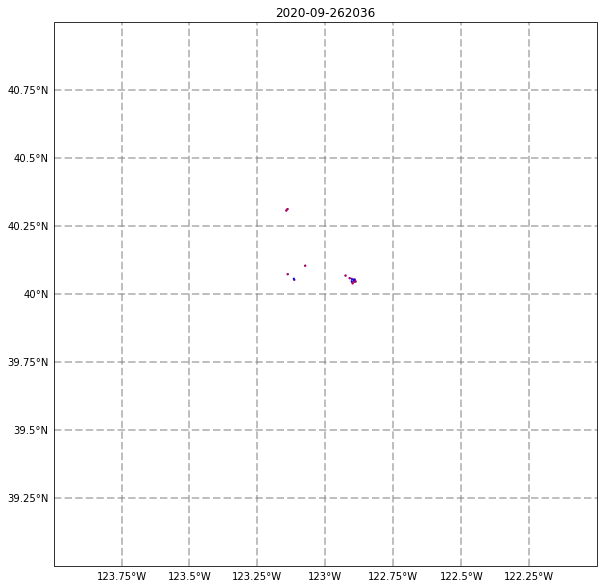

222
2 seconds
2020-09-26 2124
160
0
0 seconds
222
0 seconds
2020-09-26 2130
23
0
0 seconds
222
0 seconds
2020-09-27 806
514
0
0 seconds
222
0 seconds
2020-09-27 854
1078
44
1 seconds


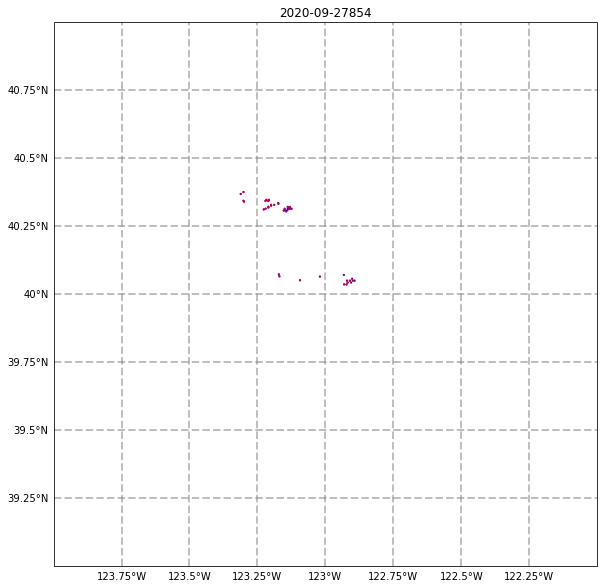

223
5 seconds
2020-09-27 942
2
0
0 seconds
223
0 seconds
2020-09-27 948
1387
205
0 seconds


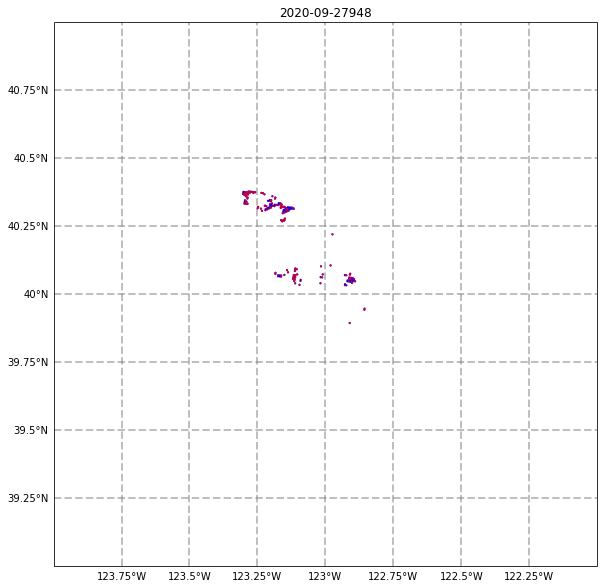

224
5 seconds
2020-09-27 1036
456
128
0 seconds


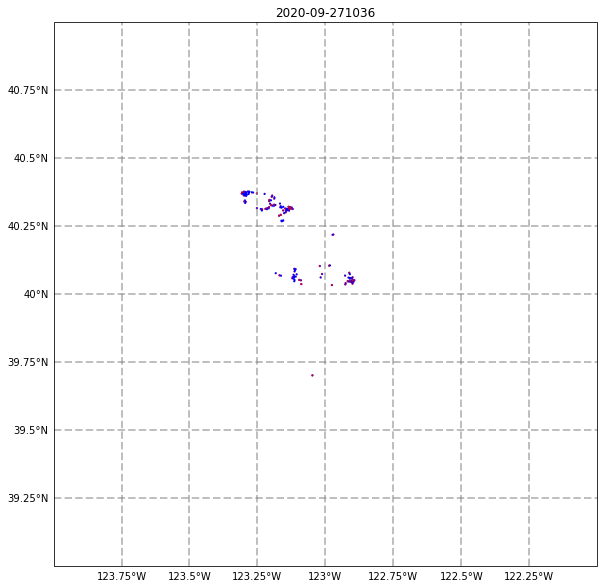

225
2 seconds
2020-09-27 1924
35
0
0 seconds
225
0 seconds
2020-09-27 1930
47
0
0 seconds
225
0 seconds
2020-09-27 2012
23
0
0 seconds
225
0 seconds
2020-09-27 2018
744
342
1 seconds


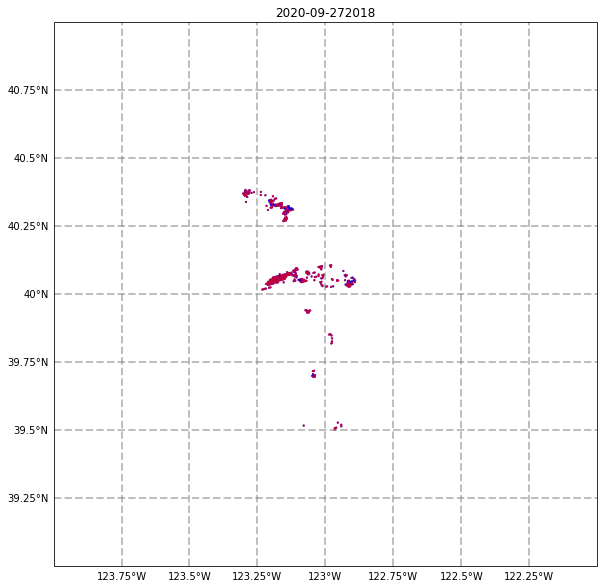

226
3 seconds
2020-09-27 2106
974
530
1 seconds


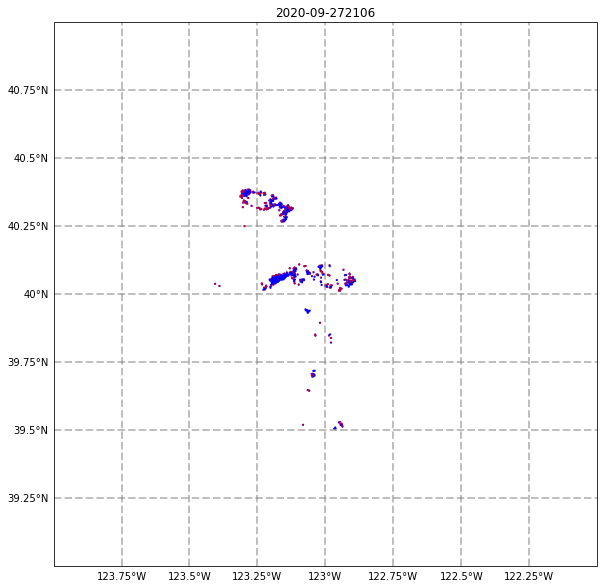

227
4 seconds
2020-09-27 2112
159
0
1 seconds
227
1 seconds
2020-09-27 2200
770
506
0 seconds


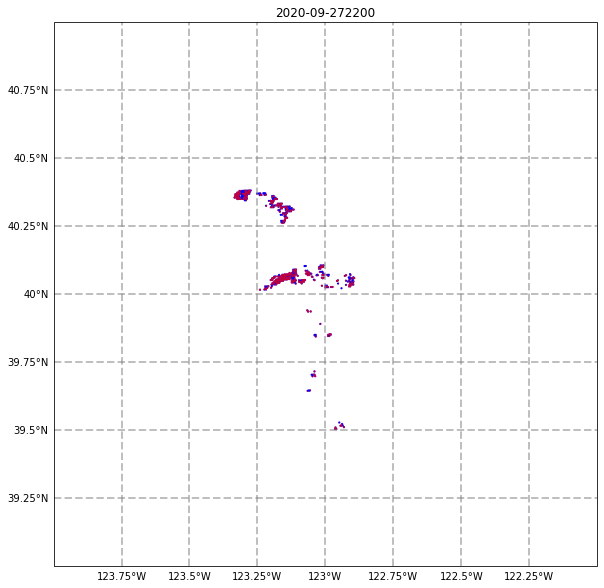

228
3 seconds
2020-09-28 742
7
0
1 seconds
228
1 seconds
2020-09-28 748
5
0
0 seconds
228
0 seconds
2020-09-28 836
273
0
0 seconds
228
0 seconds
2020-09-28 924
69
0
1 seconds
228
1 seconds
2020-09-28 930
2839
810
0 seconds


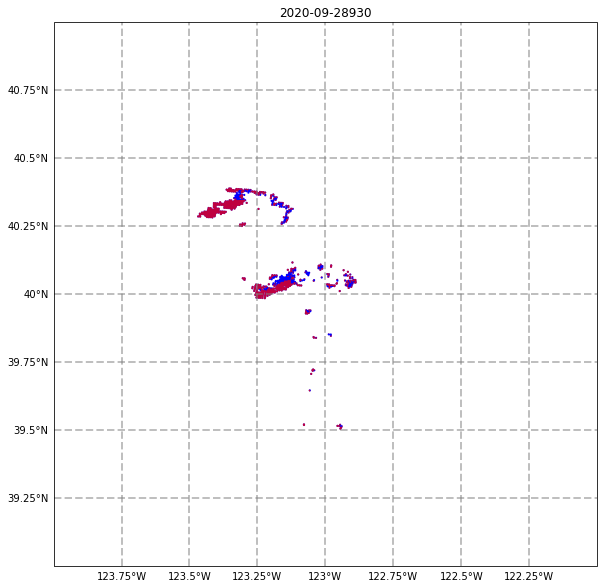

229
10 seconds
2020-09-28 1012
19
0
1 seconds
229
1 seconds
2020-09-28 1018
3519
1213
0 seconds


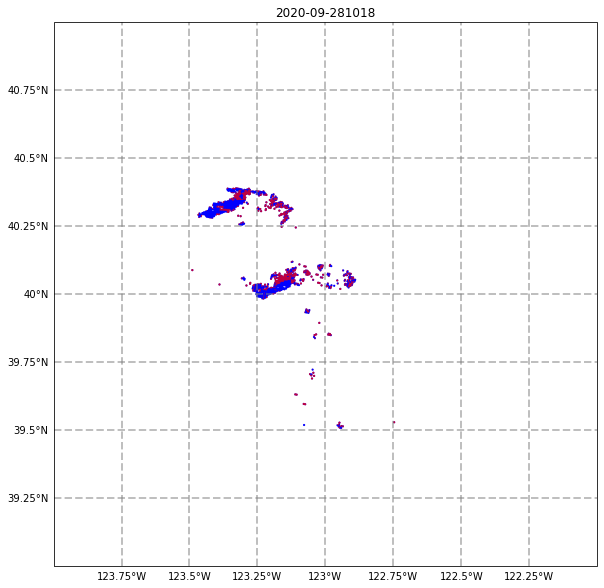

230
13 seconds
2020-09-28 1106
1833
713
1 seconds


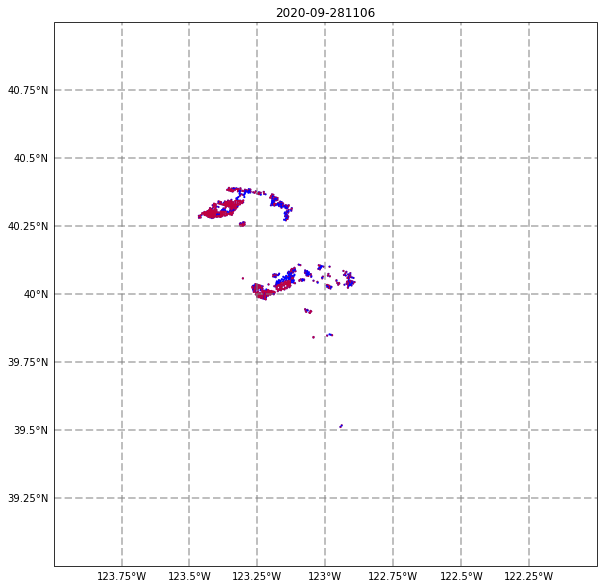

231
8 seconds
2020-09-28 1906
6
0
0 seconds
231
0 seconds
2020-09-28 1912
67
0
1 seconds
231
1 seconds
2020-09-28 1954
29
0
0 seconds
231
0 seconds
2020-09-28 2000
939
264
1 seconds


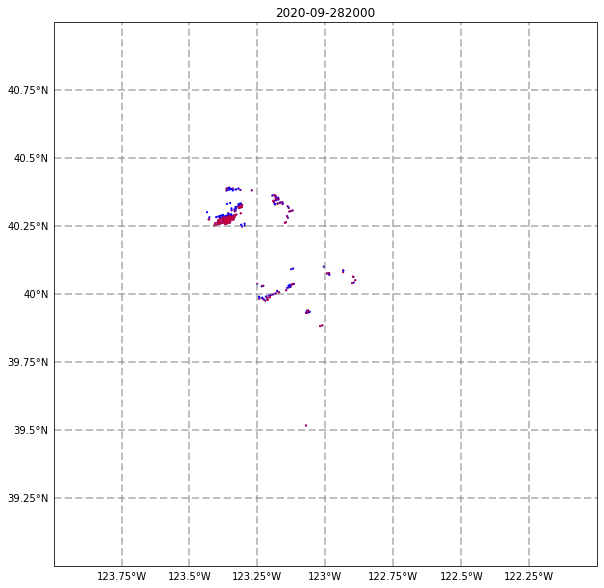

232
5 seconds
2020-09-28 2048
1785
524
0 seconds


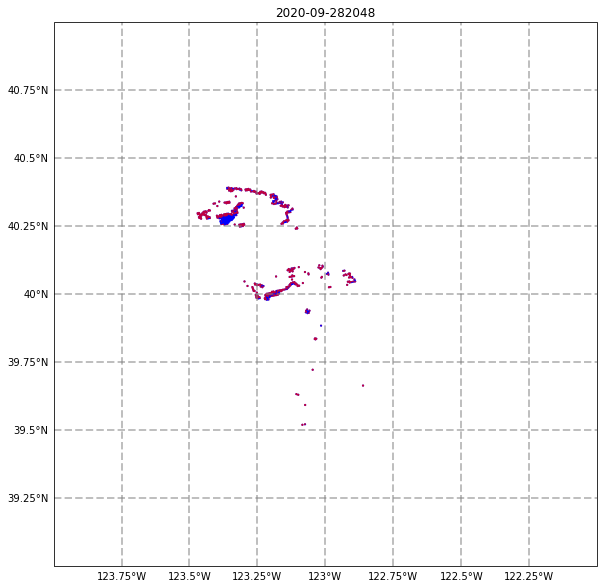

233
7 seconds
2020-09-28 2054
29
0
0 seconds
233
0 seconds
2020-09-28 2136
314
0
0 seconds
233
0 seconds
2020-09-28 2142
895
509
1 seconds


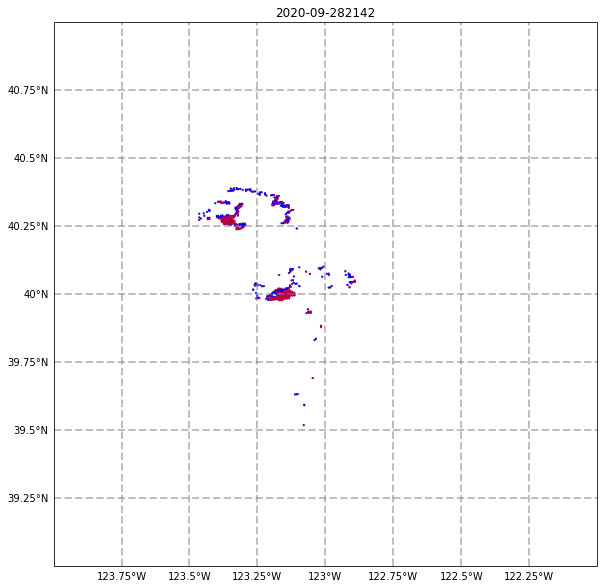

234
4 seconds
2020-09-29 730
18
0
0 seconds
234
0 seconds
2020-09-29 812
5
0
0 seconds
234
0 seconds
2020-09-29 818
159
0
1 seconds
234
1 seconds
2020-09-29 906
1467
536
0 seconds


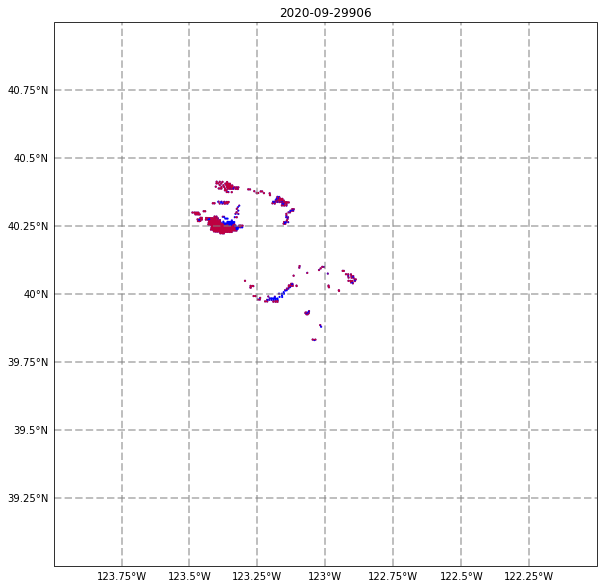

235
6 seconds
2020-09-29 912
410
0
1 seconds
235
1 seconds
2020-09-29 954
127
0
0 seconds
235
0 seconds
2020-09-29 1000
2867
1139
0 seconds


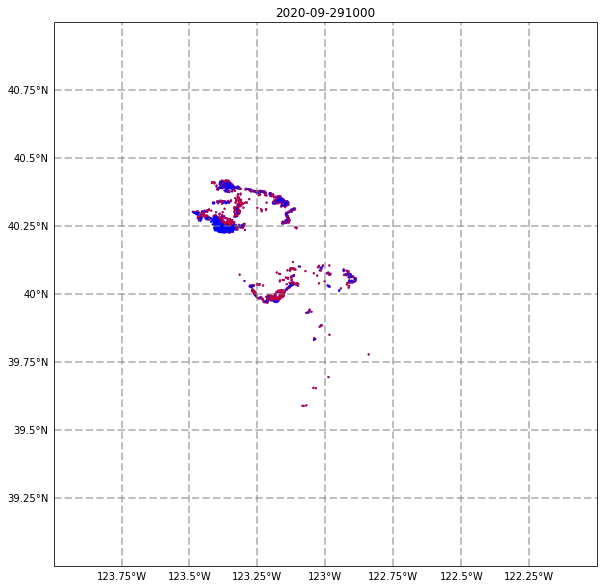

236
11 seconds
2020-09-29 1048
1790
859
1 seconds


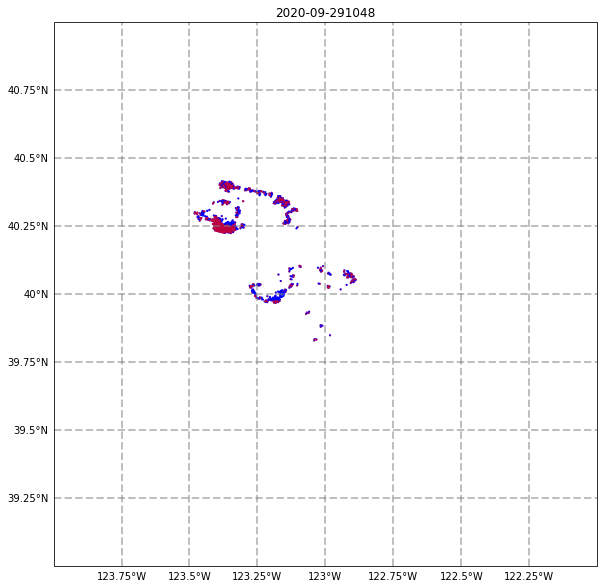

237
8 seconds
2020-09-29 1136
2
0
1 seconds
237
1 seconds
2020-09-29 1848
123
0
0 seconds
237
0 seconds
2020-09-29 1854
13
0
1 seconds
237
1 seconds
2020-09-29 1936
27
0
0 seconds
237
0 seconds
2020-09-29 1942
269
0
1 seconds
237
1 seconds
2020-09-29 2030
917
156
0 seconds


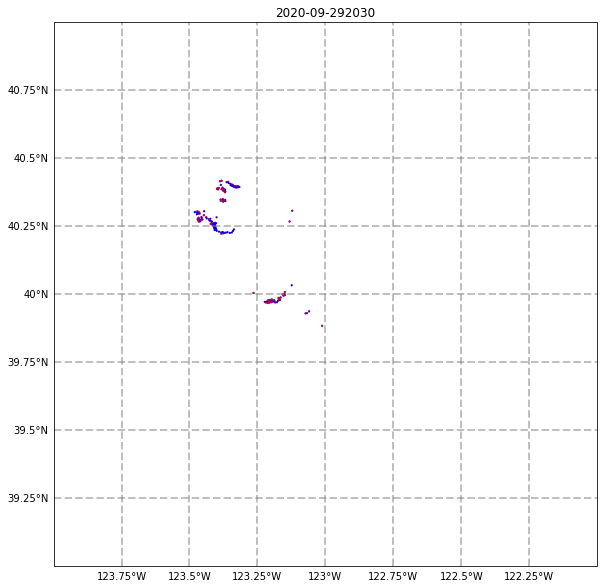

238
4 seconds
2020-09-29 2036
3
0
0 seconds
238
0 seconds
2020-09-29 2118
923
347
0 seconds


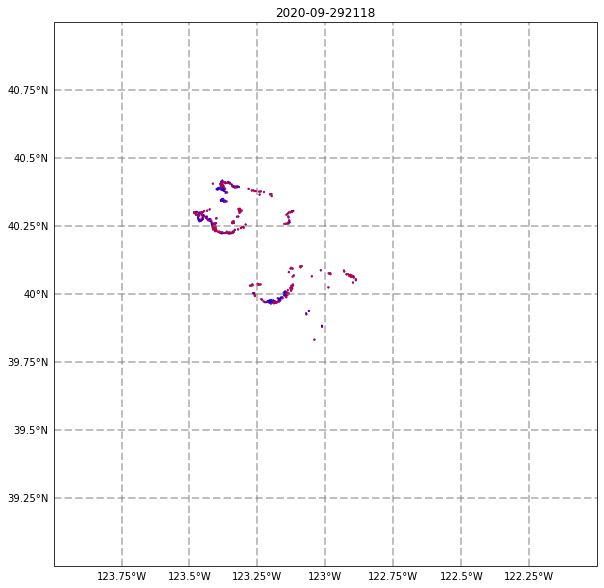

239
4 seconds
2020-09-29 2124
70
0
0 seconds
239
0 seconds
2020-09-29 2212
236
143
1 seconds


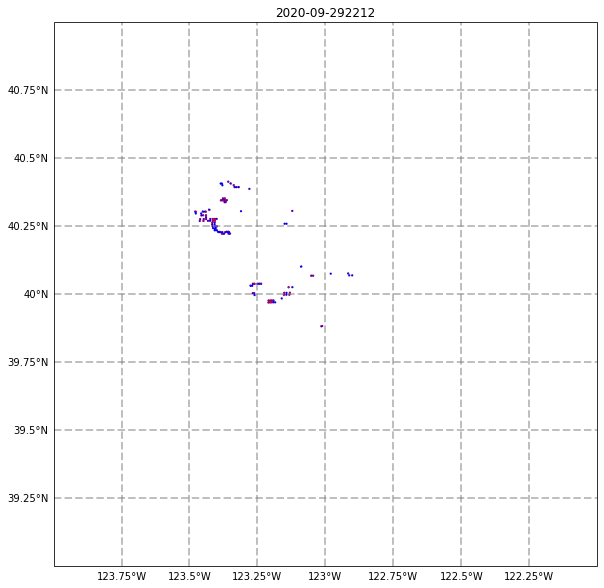

240
2 seconds
2020-09-30 754
29
0
0 seconds
240
0 seconds
2020-09-30 800
426
0
0 seconds
240
0 seconds
2020-09-30 848
937
0
1 seconds
240
1 seconds
2020-09-30 854
126
0
0 seconds
240
0 seconds
2020-09-30 936
558
0
0 seconds
240
0 seconds
2020-09-30 942
1361
415
0 seconds


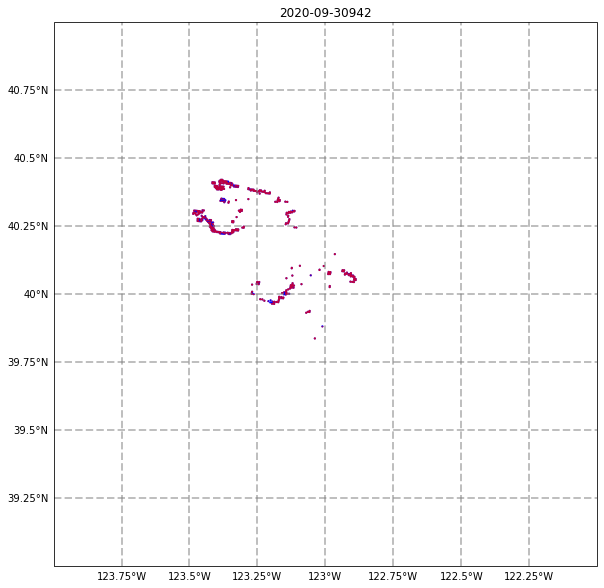

241
6 seconds
2020-09-30 1030
1299
436
0 seconds


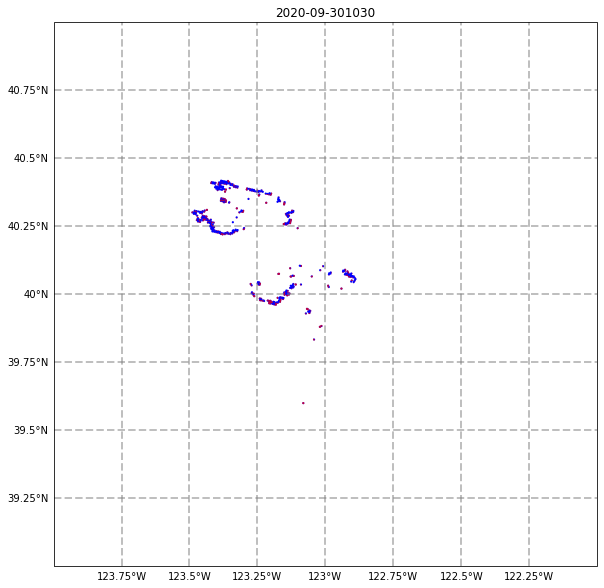

242
5 seconds
2020-09-30 1118
151
60
1 seconds


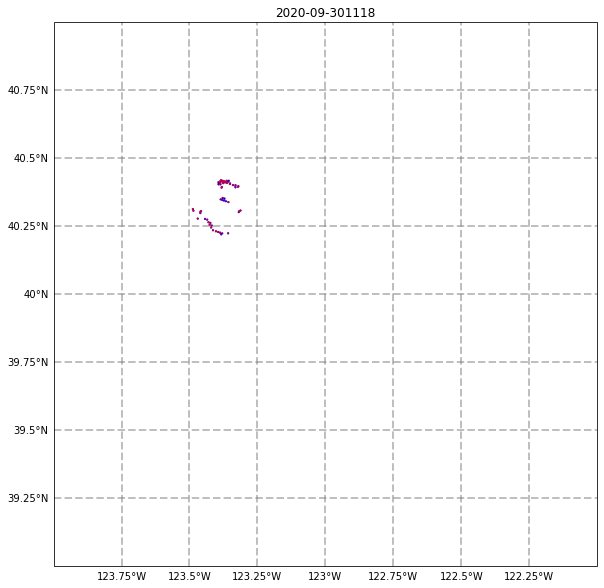

243
2 seconds
2020-09-30 1918
310
0
0 seconds
243
0 seconds
2020-09-30 1924
28
0
0 seconds
243
0 seconds
2020-09-30 2012
1000
91
0 seconds


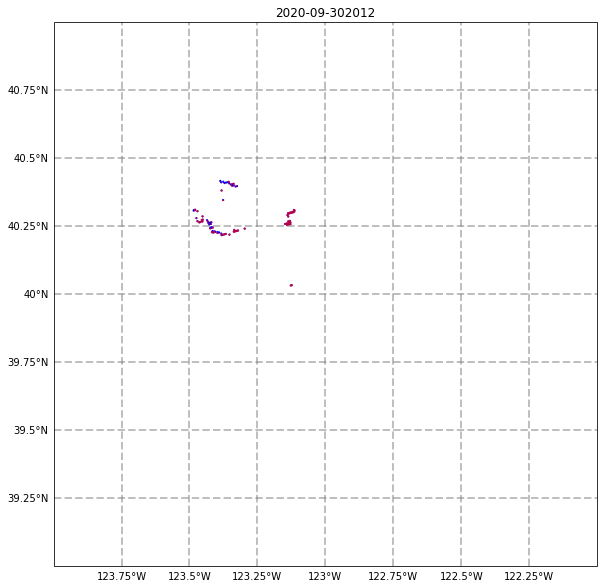

244
4 seconds
2020-09-30 2100
1515
277
0 seconds


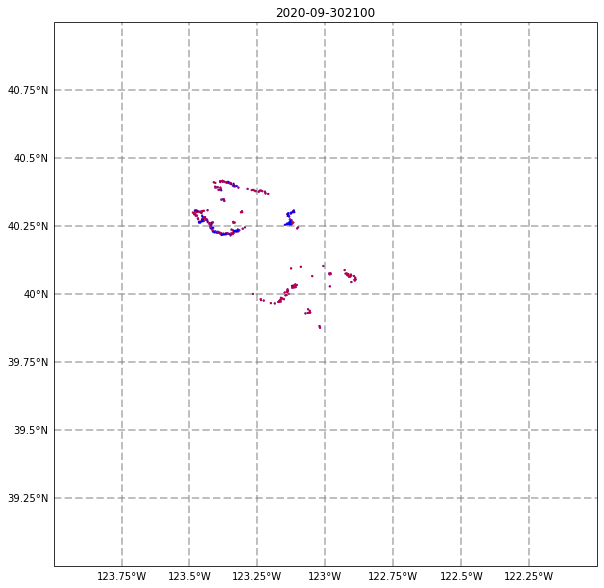

245
6 seconds
2020-09-30 2106
20
0
1 seconds
245
1 seconds
2020-09-30 2148
87
0
0 seconds
245
0 seconds
2020-09-30 2154
562
222
0 seconds


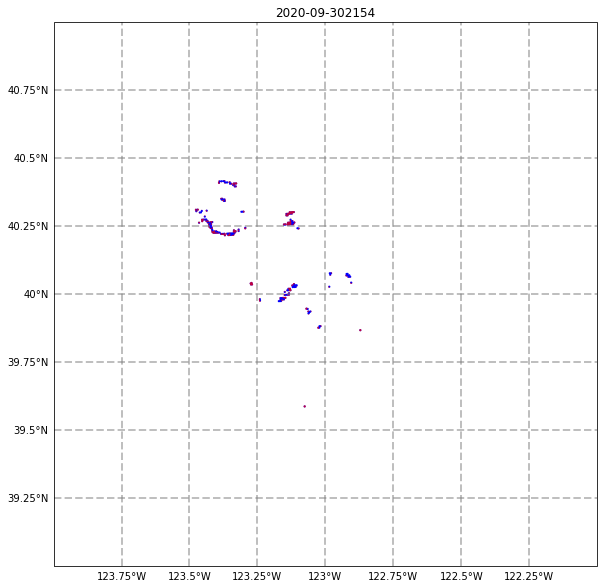

246
3 seconds
2020-10-01 736
9
0
0 seconds
246
0 seconds
2020-10-01 742
42
0
0 seconds
246
0 seconds
2020-10-01 830
646
0
0 seconds
246
0 seconds
2020-10-01 918
1451
385
1 seconds


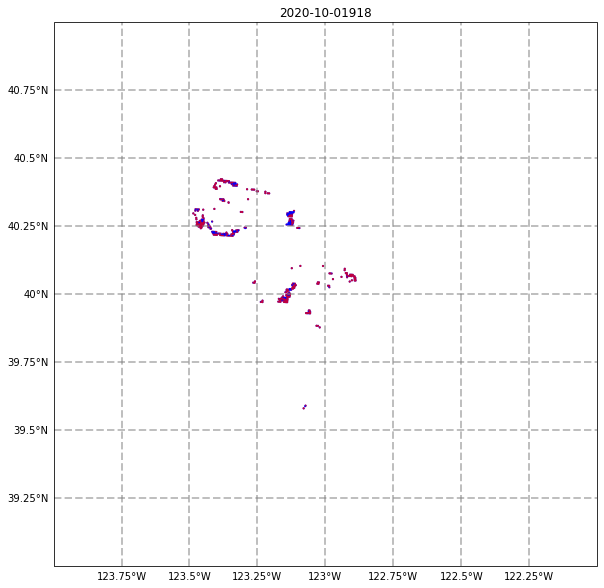

247
6 seconds
2020-10-01 924
329
0
1 seconds
247
1 seconds
2020-10-01 1006
10
0
0 seconds
247
0 seconds
2020-10-01 1012
1744
552
0 seconds


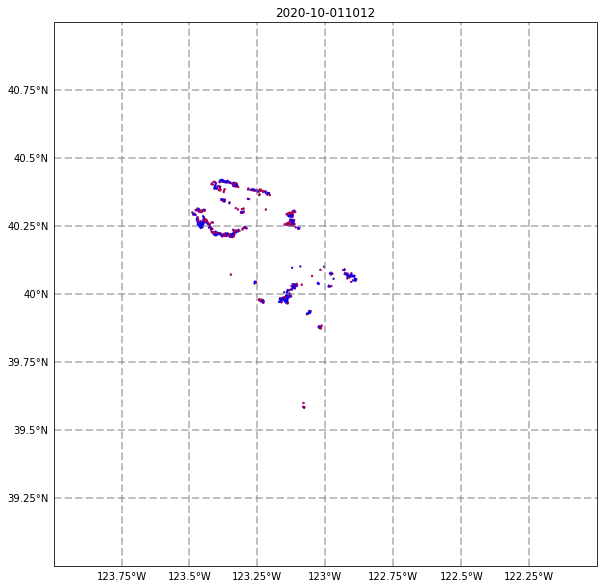

248
7 seconds
2020-10-01 1100
530
215
1 seconds


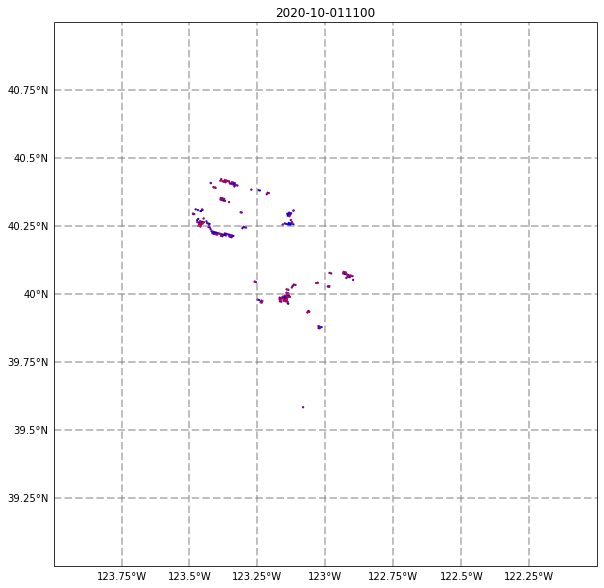

249
3 seconds
2020-10-01 1812
2
0
0 seconds
249
0 seconds
2020-10-01 1900
182
0
1 seconds
249
1 seconds
2020-10-01 1906
2
0
0 seconds
249
0 seconds
2020-10-01 1948
13
0
0 seconds
249
0 seconds
2020-10-01 1954
741
67
0 seconds


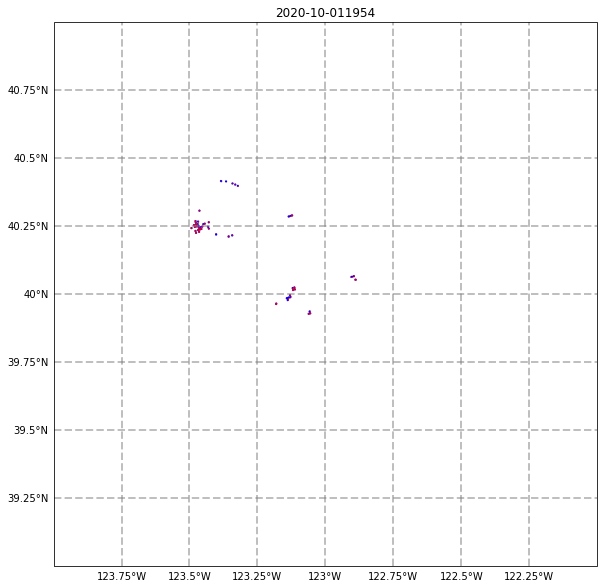

250
4 seconds
2020-10-01 2042
1230
176
0 seconds


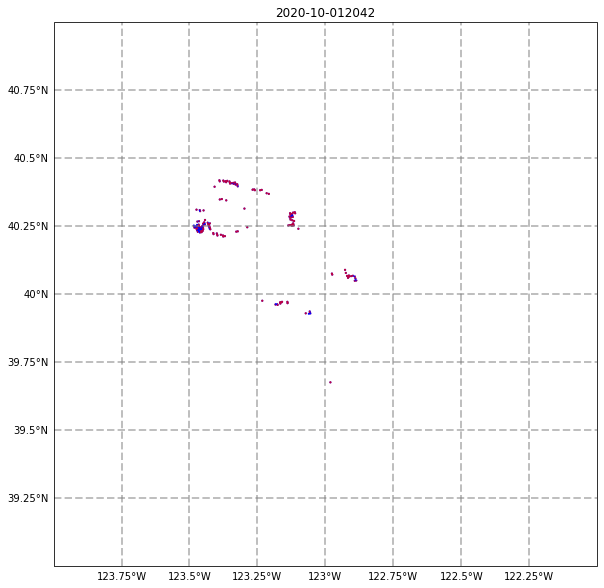

251
5 seconds
2020-10-01 2130
181
0
0 seconds
251
0 seconds
2020-10-01 2136
574
172
0 seconds


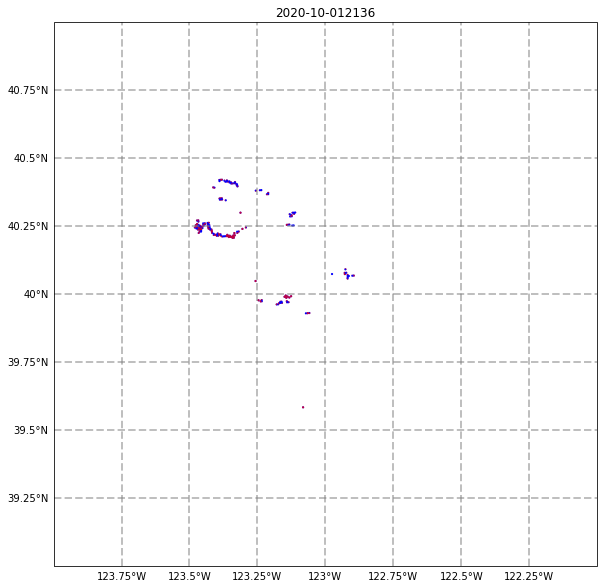

252
3 seconds
2020-10-02 812
161
0
0 seconds
252
0 seconds
2020-10-02 900
1138
179
0 seconds


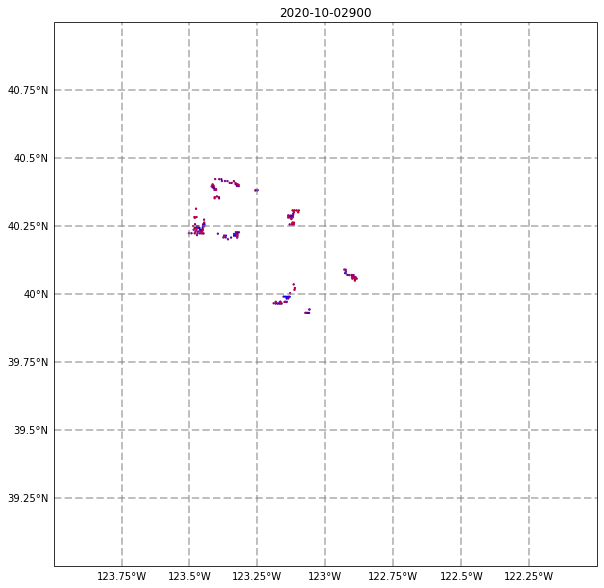

253
5 seconds
2020-10-02 906
28
0
0 seconds
253
0 seconds
2020-10-02 948
5
0
0 seconds
253
0 seconds
2020-10-02 954
1712
475
1 seconds


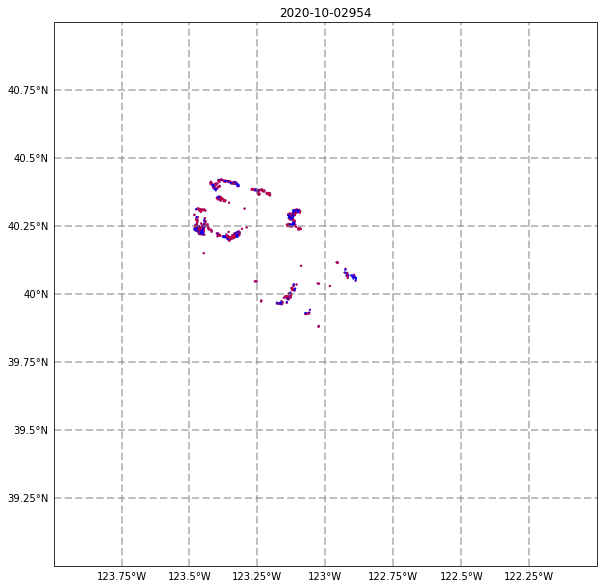

254
8 seconds
2020-10-02 1042
766
246
0 seconds


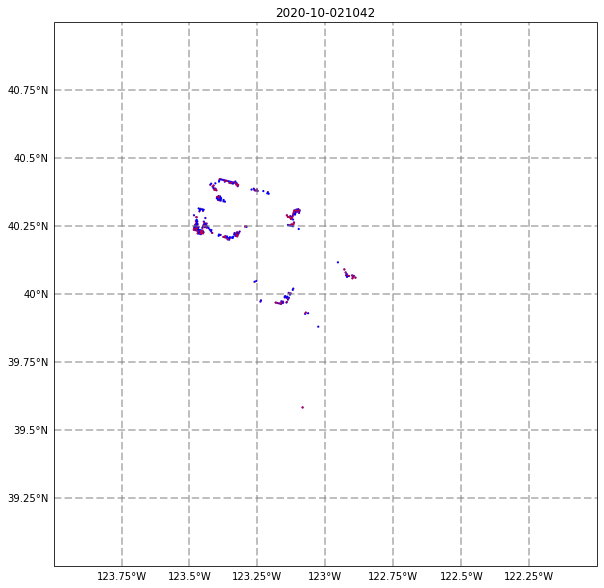

255
3 seconds
2020-10-02 1130
3
0
0 seconds
255
0 seconds
2020-10-02 1842
84
0
1 seconds
255
1 seconds
2020-10-02 1930
54
0
0 seconds
255
0 seconds
2020-10-02 1936
230
0
0 seconds
255
0 seconds
2020-10-02 2018
4
0
1 seconds
255
1 seconds
2020-10-02 2024
826
34
0 seconds


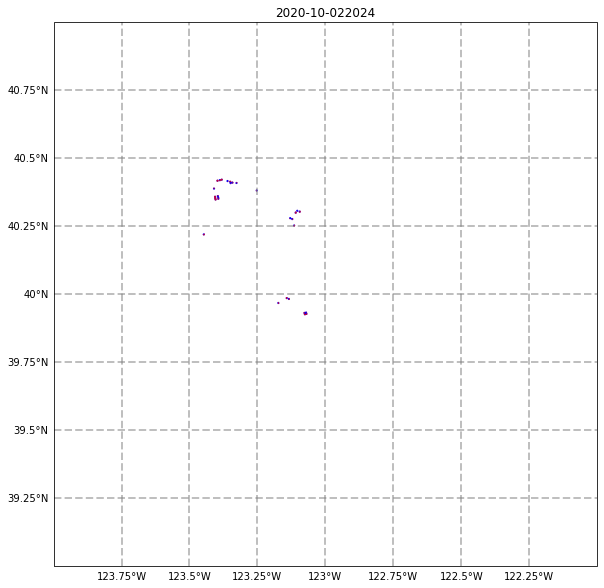

256
3 seconds
2020-10-02 2112
464
0
1 seconds
256
1 seconds
2020-10-02 2118
317
200
0 seconds


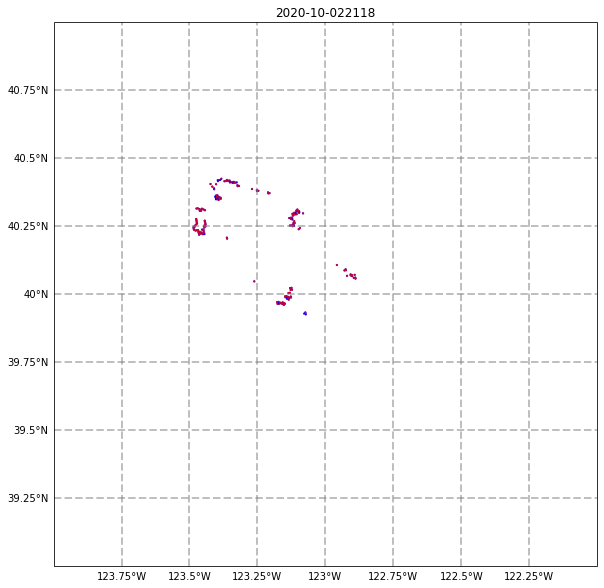

257
1 seconds
2020-10-02 2206
140
54
0 seconds


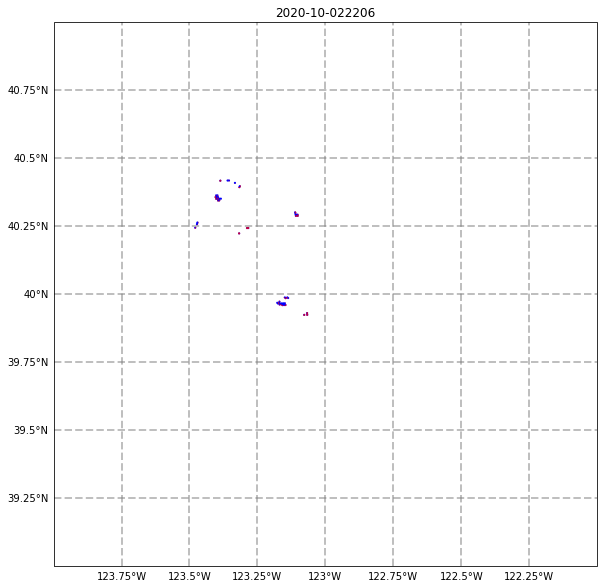

258
1 seconds
2020-10-03 748
9
0
0 seconds
258
0 seconds
2020-10-03 754
176
0
1 seconds
258
1 seconds
2020-10-03 842
851
0
0 seconds
258
0 seconds
2020-10-03 930
249
0
0 seconds
258
0 seconds
2020-10-03 936
1327
273
0 seconds


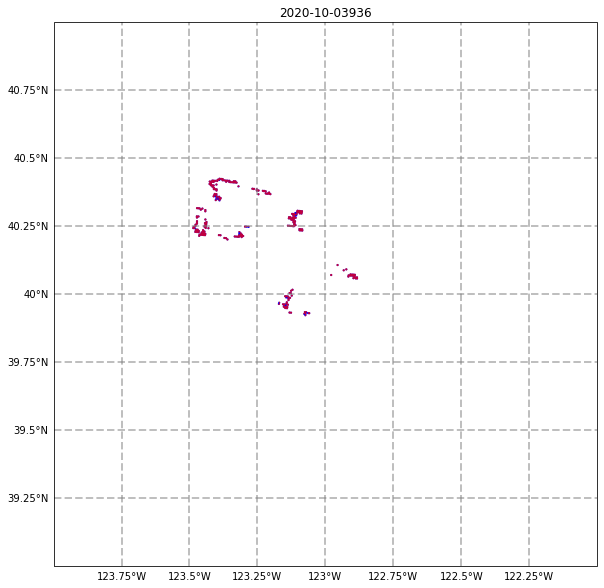

259
5 seconds
2020-10-03 1018
6
0
1 seconds
259
1 seconds
2020-10-03 1024
1139
335
0 seconds


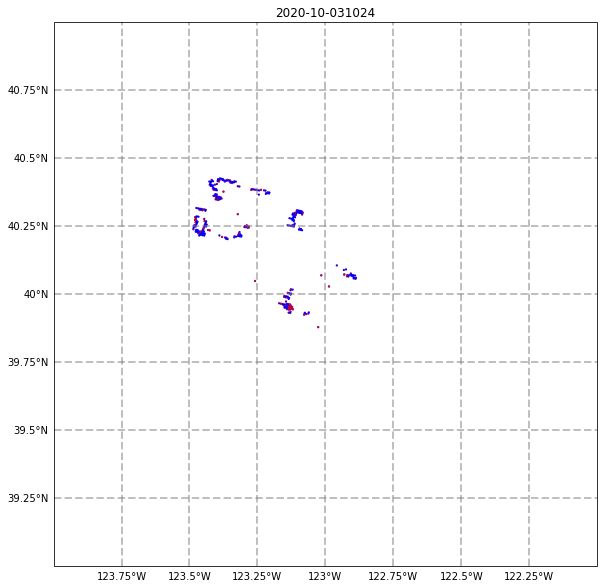

260
5 seconds
2020-10-03 1112
203
144
0 seconds


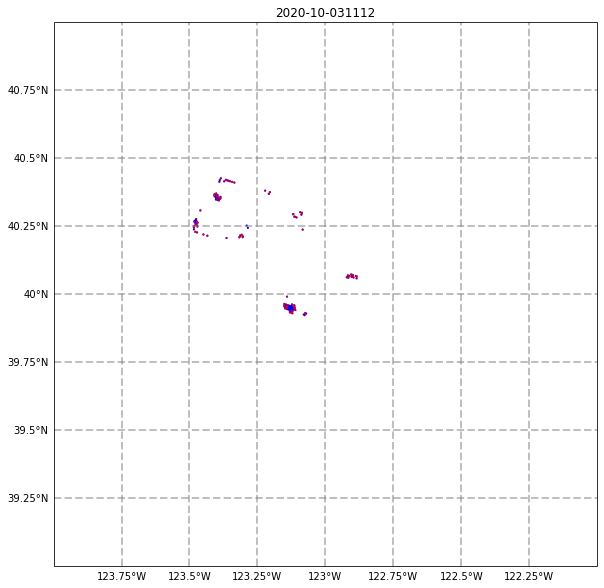

261
1 seconds
2020-10-03 1824
8
0
0 seconds
261
0 seconds
2020-10-03 1912
34
0
0 seconds
261
0 seconds
2020-10-03 1918
133
0
1 seconds
261
1 seconds
2020-10-03 2000
121
0
0 seconds
261
0 seconds
2020-10-03 2006
600
94
0 seconds


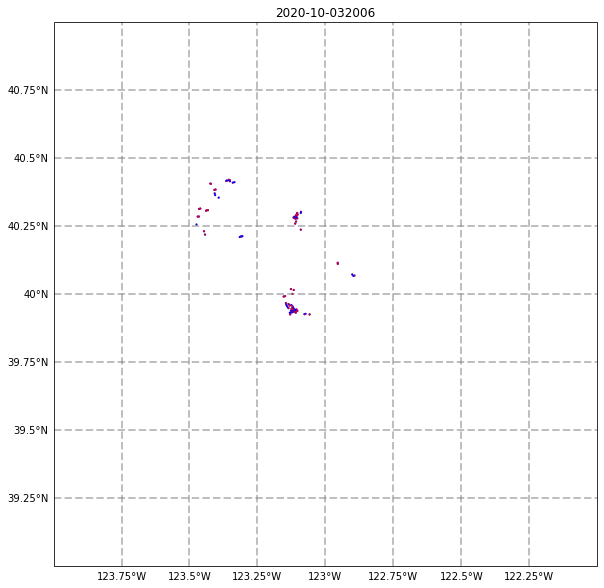

262
3 seconds
2020-10-03 2054
1147
316
0 seconds


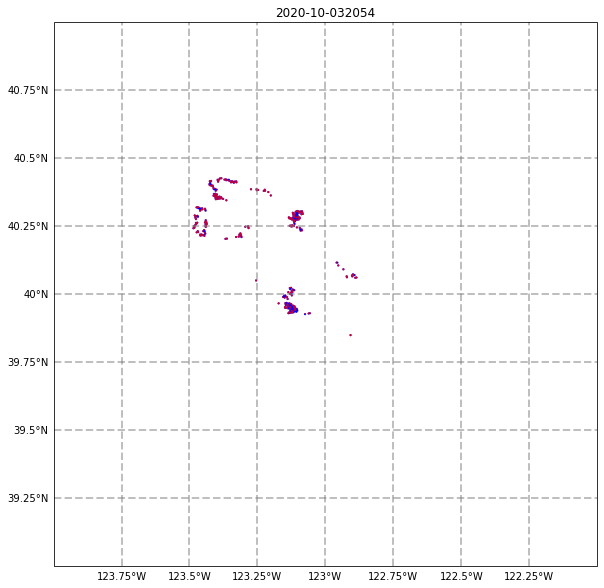

263
5 seconds
2020-10-03 2100
28
0
0 seconds
263
0 seconds
2020-10-03 2142
250
0
0 seconds
263
0 seconds
2020-10-03 2148
307
215
1 seconds


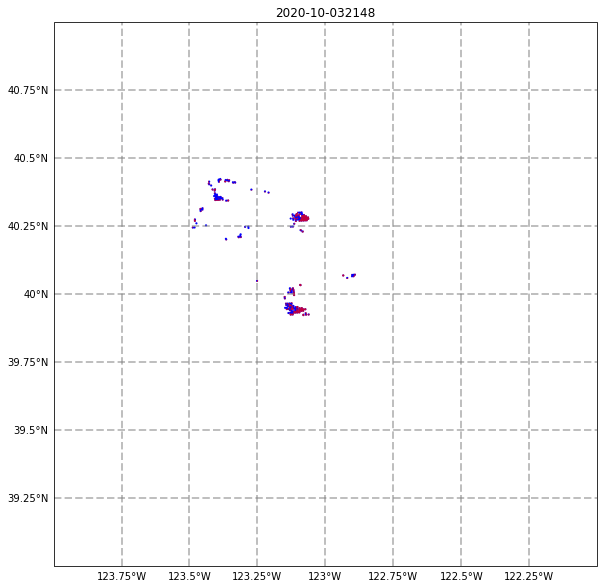

264
2 seconds
2020-10-04 730
3
0
0 seconds
264
0 seconds
2020-10-04 736
33
0
0 seconds
264
0 seconds
2020-10-04 818
18
0
1 seconds
264
1 seconds
2020-10-04 824
312
0
0 seconds
264
0 seconds
2020-10-04 912
959
548
0 seconds


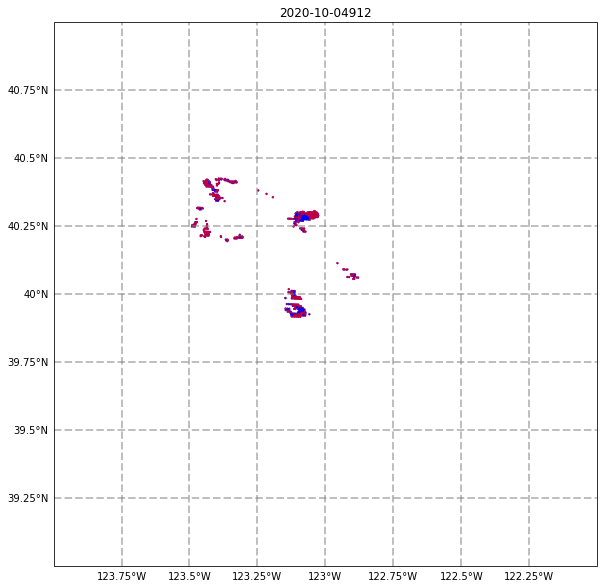

265
5 seconds
2020-10-04 918
593
0
0 seconds
265
0 seconds
2020-10-04 1000
61
0
0 seconds
265
0 seconds
2020-10-04 1006
1708
801
0 seconds


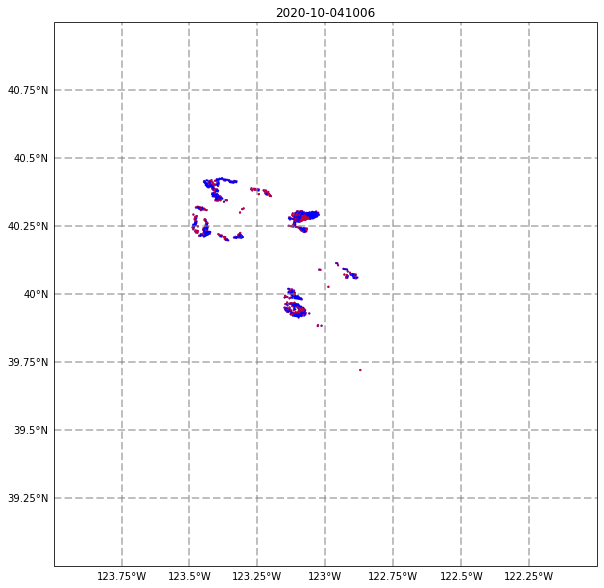

266
7 seconds
2020-10-04 1054
683
454
1 seconds


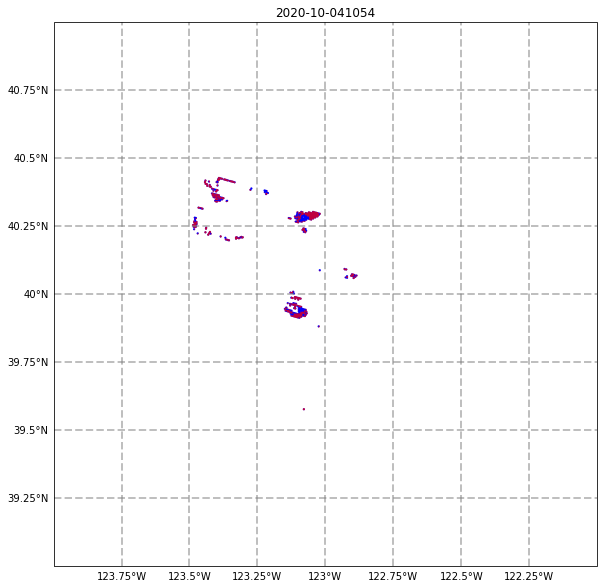

267
4 seconds
2020-10-04 1806
4
0
0 seconds
267
0 seconds
2020-10-04 1854
190
0
1 seconds
267
1 seconds
2020-10-04 1900
51
0
0 seconds
267
0 seconds
2020-10-04 1942
68
0
0 seconds
267
0 seconds
2020-10-04 1948
562
0
0 seconds
267
0 seconds
2020-10-04 2036
1168
146
1 seconds


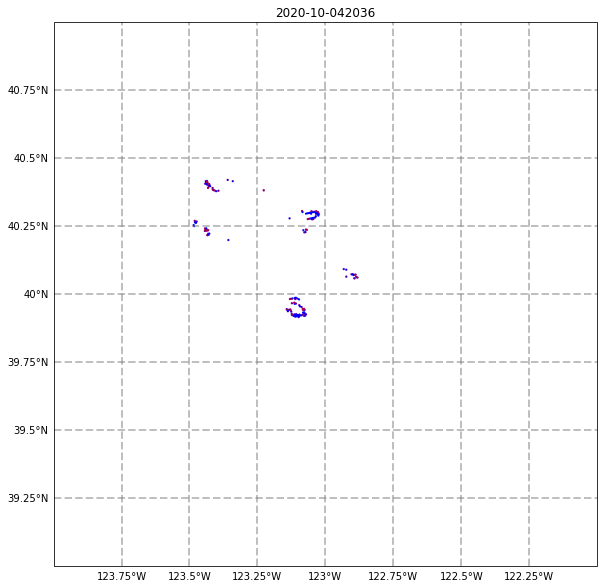

268
6 seconds
2020-10-04 2042
23
0
0 seconds
268
0 seconds
2020-10-04 2124
465
130
0 seconds


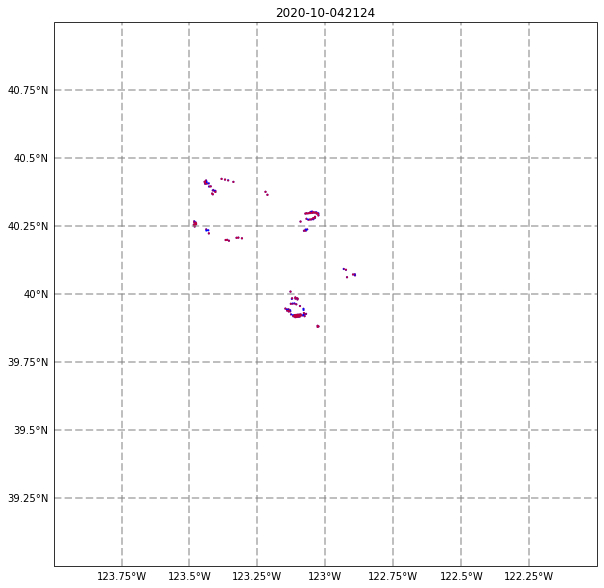

269
2 seconds
2020-10-04 2130
90
0
1 seconds
269
1 seconds
2020-10-04 2218
16
5
0 seconds


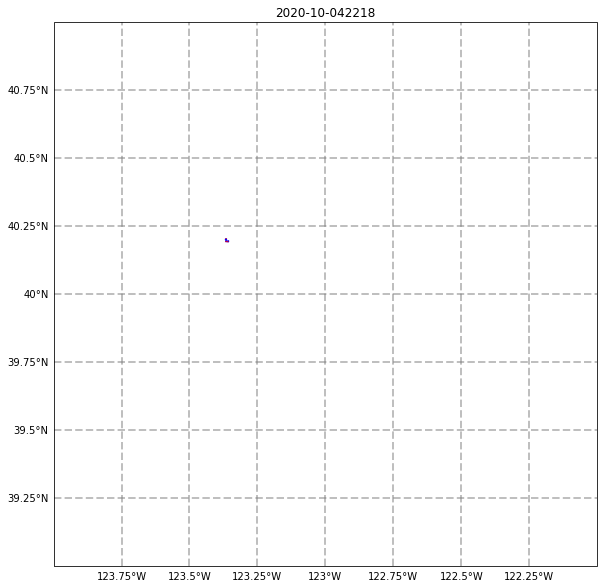

270
0 seconds
2020-10-05 800
40
0
0 seconds
270
0 seconds
2020-10-05 806
558
0
0 seconds
270
0 seconds
2020-10-05 854
1641
26
1 seconds


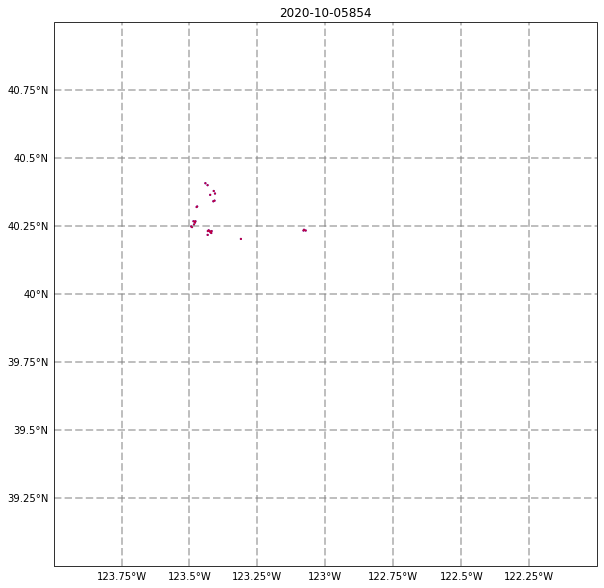

271
7 seconds
2020-10-05 900
157
0
1 seconds
271
1 seconds
2020-10-05 942
647
0
0 seconds
271
0 seconds
2020-10-05 948
1348
265
0 seconds


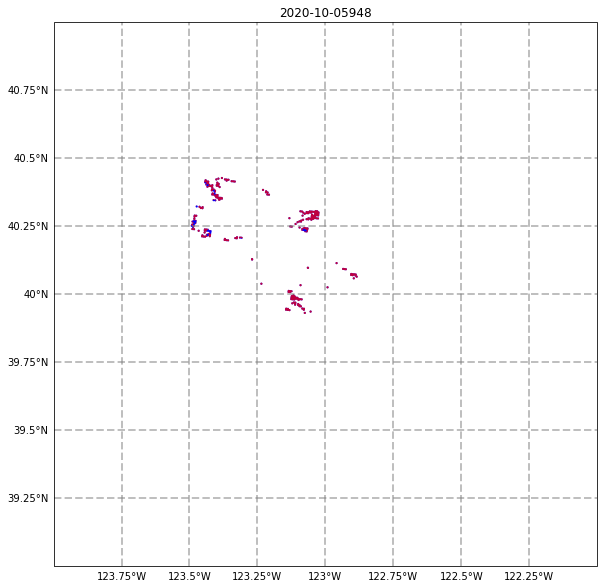

272
6 seconds
2020-10-05 1036
910
240
0 seconds


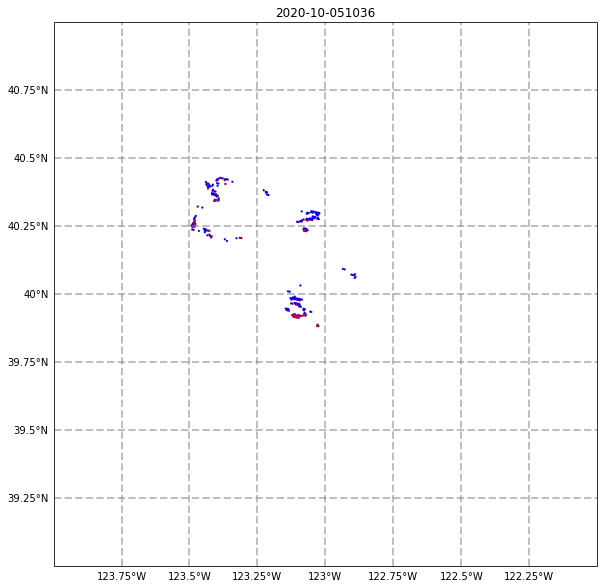

273
4 seconds
2020-10-05 1124
5
0
0 seconds
273
0 seconds
2020-10-05 1842
1
0
1 seconds
273
1 seconds
2020-10-05 1924
113
0
0 seconds
273
0 seconds
2020-10-05 1930
468
0
0 seconds
273
0 seconds
2020-10-05 2018
1132
101
0 seconds


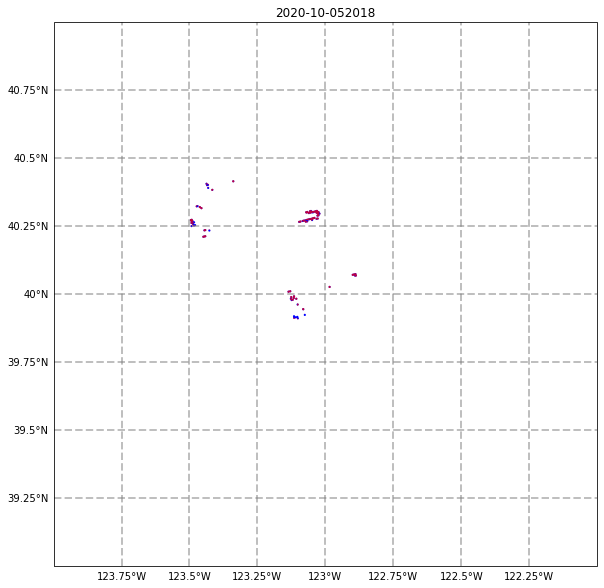

274
5 seconds
2020-10-05 2106
1007
172
1 seconds


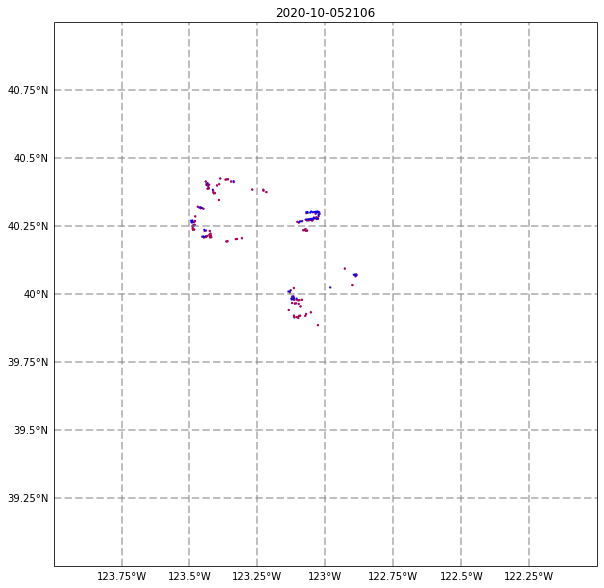

275
5 seconds
2020-10-05 2112
107
0
0 seconds
275
0 seconds
2020-10-05 2200
247
64
0 seconds


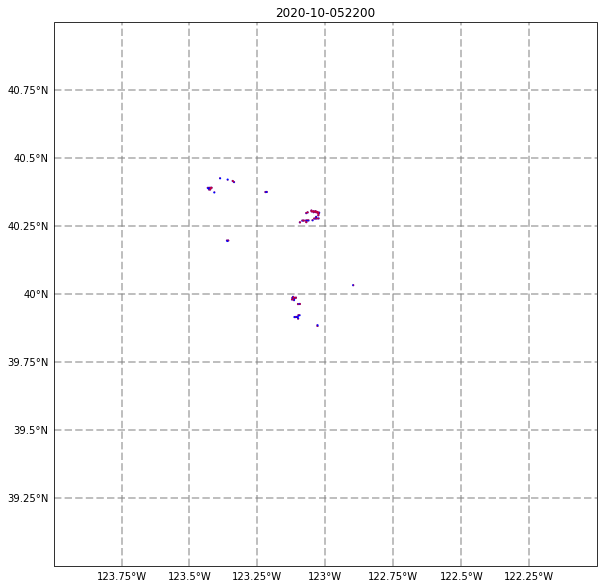

276
2 seconds
2020-10-06 742
93
0
0 seconds
276
0 seconds
2020-10-06 748
53
0
0 seconds
276
0 seconds
2020-10-06 836
844
0
0 seconds
276
0 seconds
2020-10-06 924
894
201
0 seconds


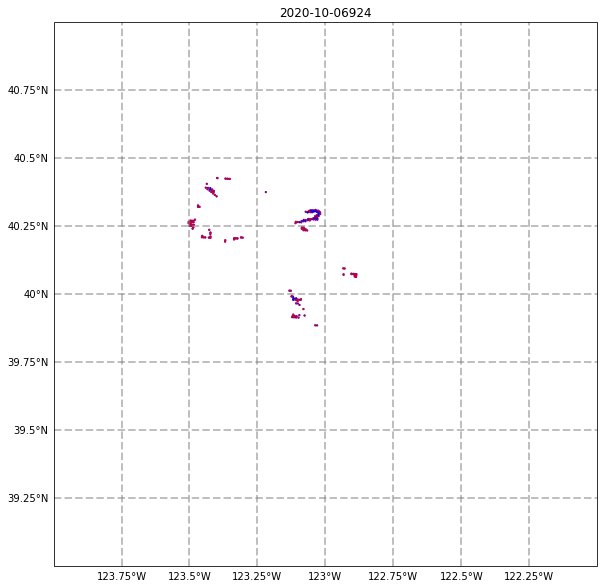

277
4 seconds
2020-10-06 930
746
0
0 seconds
277
0 seconds
2020-10-06 1012
4
0
1 seconds
277
1 seconds
2020-10-06 1018
987
329
0 seconds


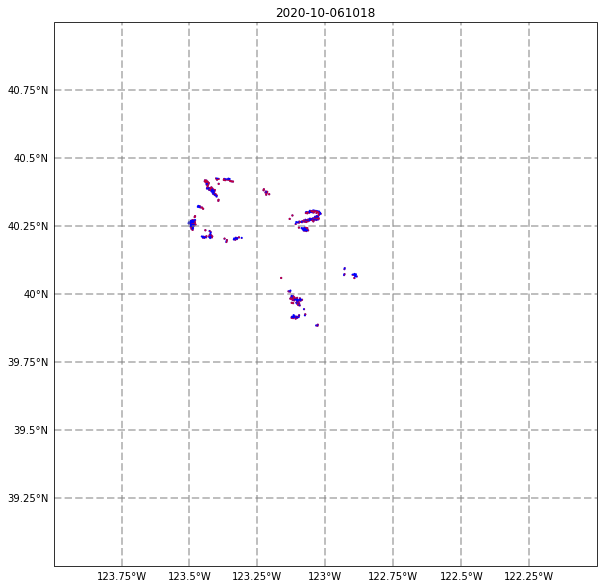

278
4 seconds
2020-10-06 1106
211
129
1 seconds


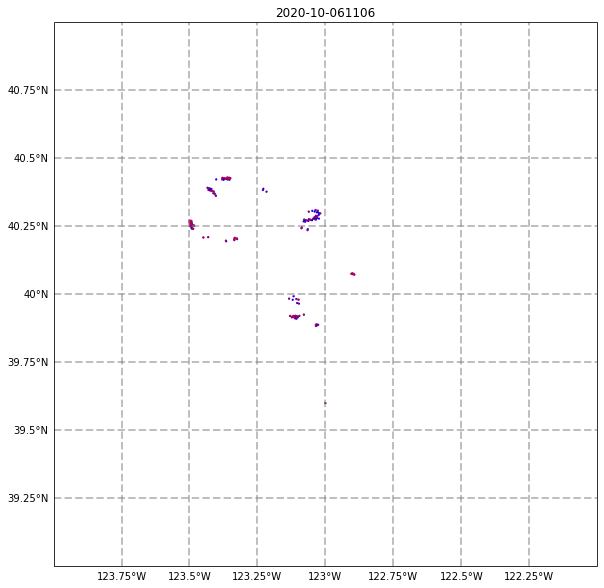

279
2 seconds
2020-10-06 1818
3
0
0 seconds
279
0 seconds
2020-10-06 1906
370
0
0 seconds
279
0 seconds
2020-10-06 1912
40
0
0 seconds
279
0 seconds
2020-10-06 1954
14
0
1 seconds
279
1 seconds
2020-10-06 2000
989
69
0 seconds


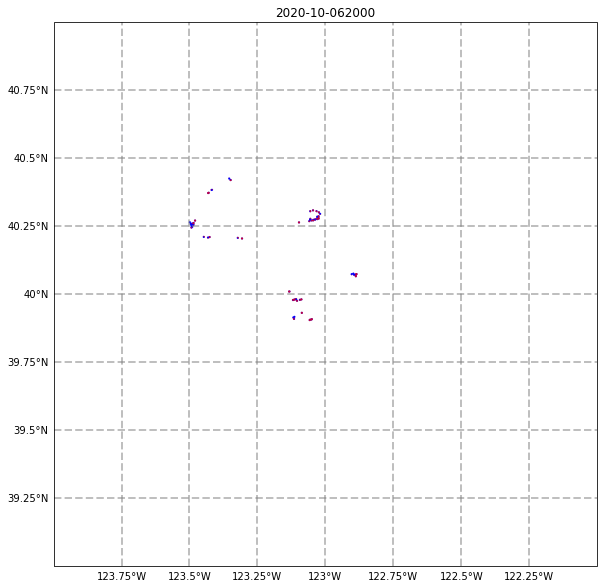

280
4 seconds
2020-10-06 2048
1167
162
0 seconds


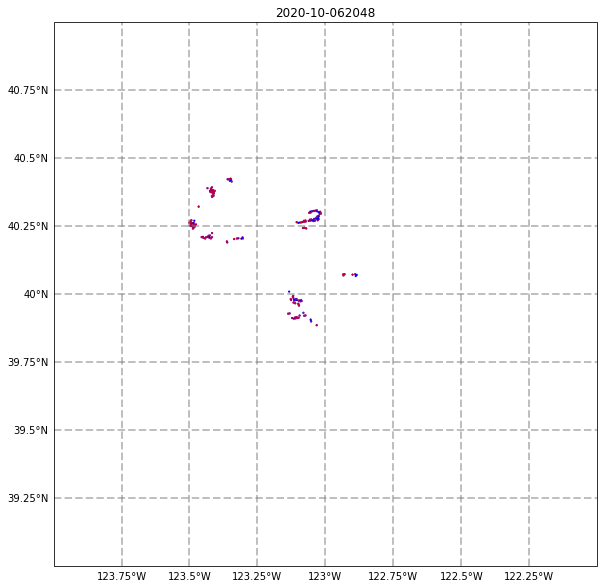

281
5 seconds
2020-10-06 2054
5
0
1 seconds
281
1 seconds
2020-10-06 2136
1
0
0 seconds
281
0 seconds
2020-10-06 2142
430
138
0 seconds


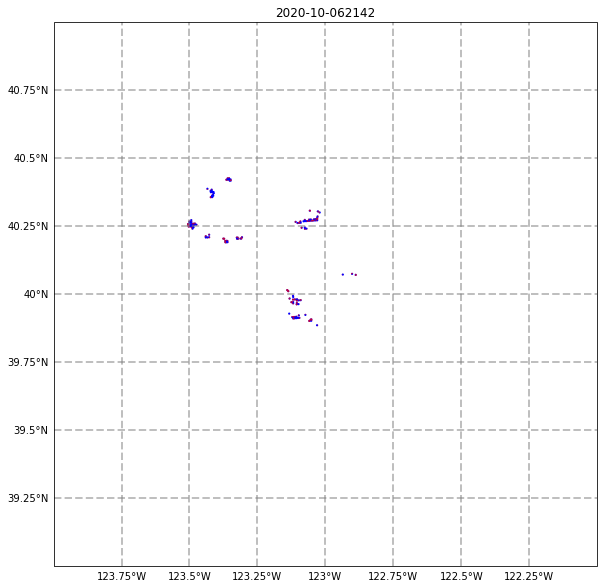

282
2 seconds
2020-10-07 730
18
0
0 seconds
282
0 seconds
2020-10-07 818
488
0
1 seconds
282
1 seconds
2020-10-07 906
1377
204
0 seconds


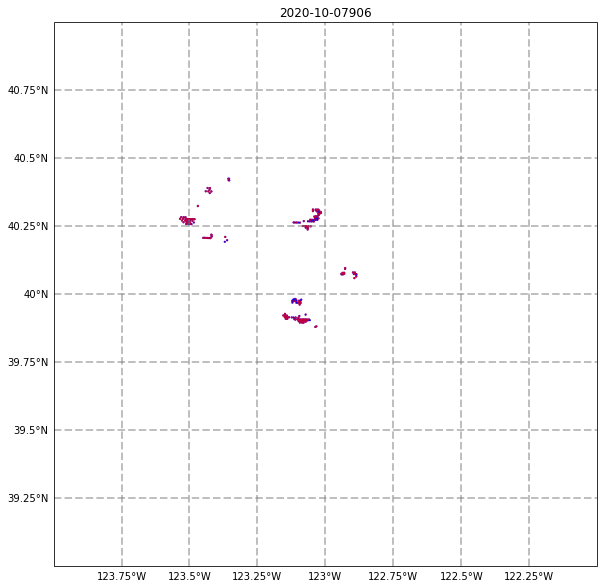

283
6 seconds
2020-10-07 912
198
0
0 seconds
283
0 seconds
2020-10-07 954
18
0
0 seconds
283
0 seconds
2020-10-07 1000
1504
416
0 seconds


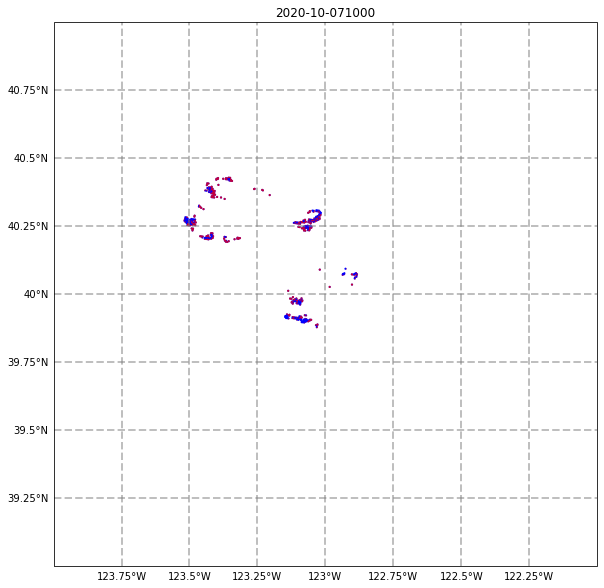

284
7 seconds
2020-10-07 1048
622
242
0 seconds


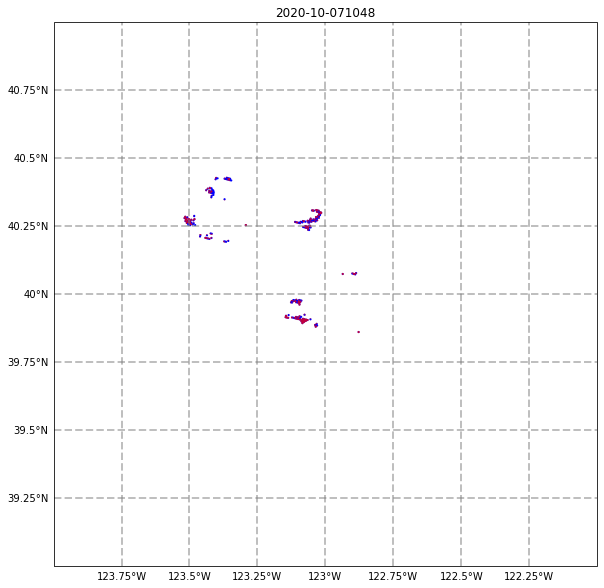

285
3 seconds
2020-10-07 1136
1
0
1 seconds
285
1 seconds
2020-10-07 1848
151
0
0 seconds
285
0 seconds
2020-10-07 1854
8
0
0 seconds
285
0 seconds
2020-10-07 1936
106
0
0 seconds
285
0 seconds
2020-10-07 1942
494
0
1 seconds
285
1 seconds
2020-10-07 2030
979
159
0 seconds


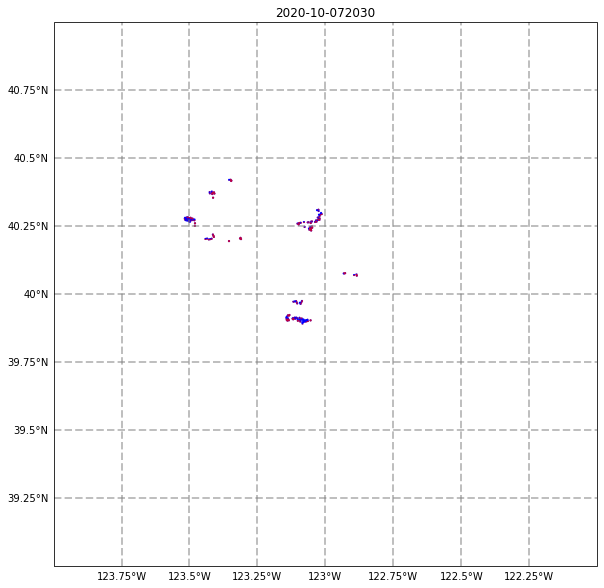

286
4 seconds
2020-10-07 2118
329
0
0 seconds
286
0 seconds
2020-10-07 2124
415
189
1 seconds


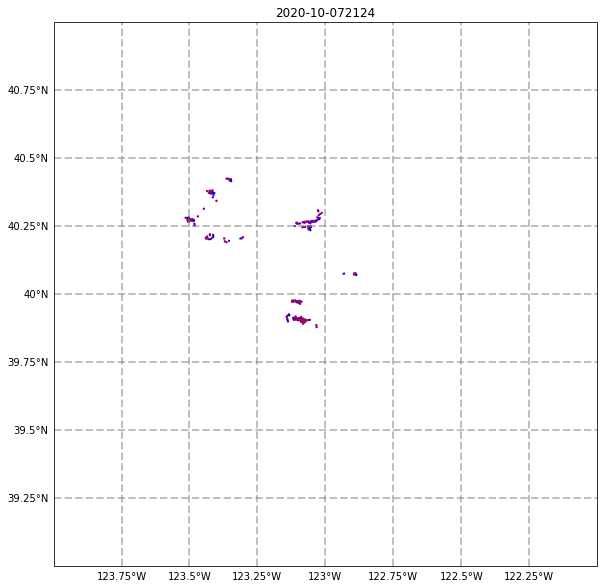

287
3 seconds
2020-10-07 2212
171
115
0 seconds


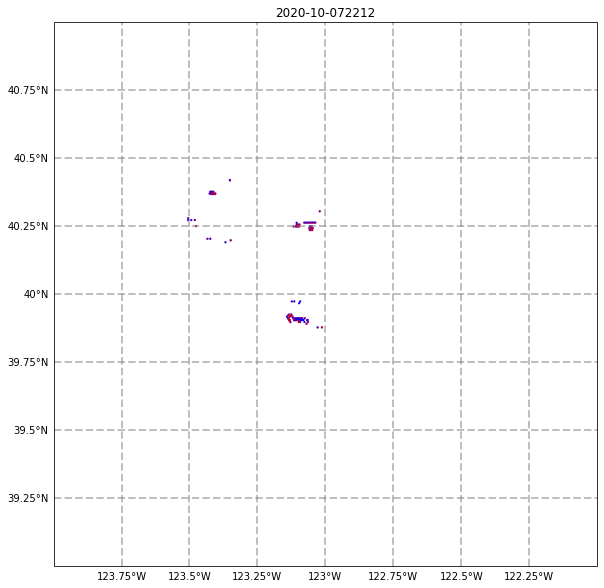

288
1 seconds
2020-10-08 754
18
0
0 seconds
288
0 seconds
2020-10-08 800
242
0
0 seconds
288
0 seconds
2020-10-08 848
1020
0
0 seconds
288
0 seconds
2020-10-08 936
173
0
0 seconds
288
0 seconds
2020-10-08 942
1070
158
1 seconds


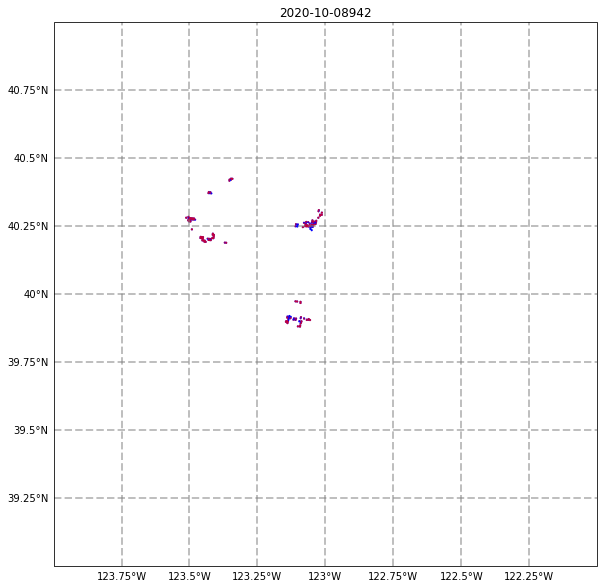

289
5 seconds
2020-10-08 1024
2
0
1 seconds
289
1 seconds
2020-10-08 1030
364
44
0 seconds


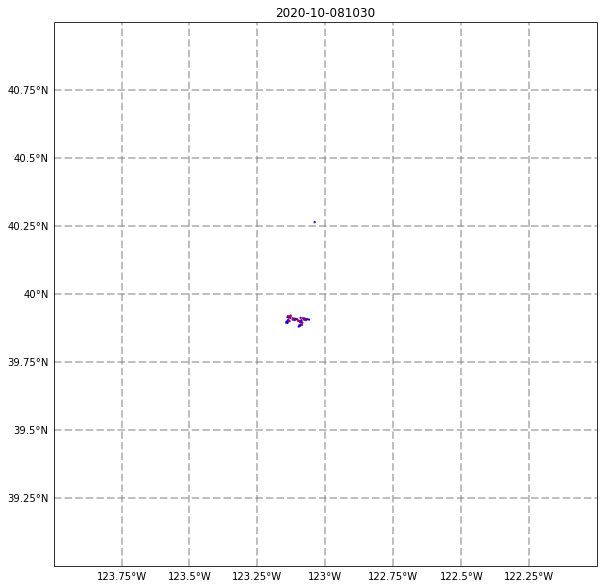

290
1 seconds
2020-10-08 1118
25
0
1 seconds
290
1 seconds
2020-10-08 1830
7
0
0 seconds
290
0 seconds
2020-10-08 1918
62
0
0 seconds
290
0 seconds
2020-10-08 1924
420
0
0 seconds
290
0 seconds
2020-10-08 2006
40
0
0 seconds
290
0 seconds
2020-10-08 2012
809
2
0 seconds


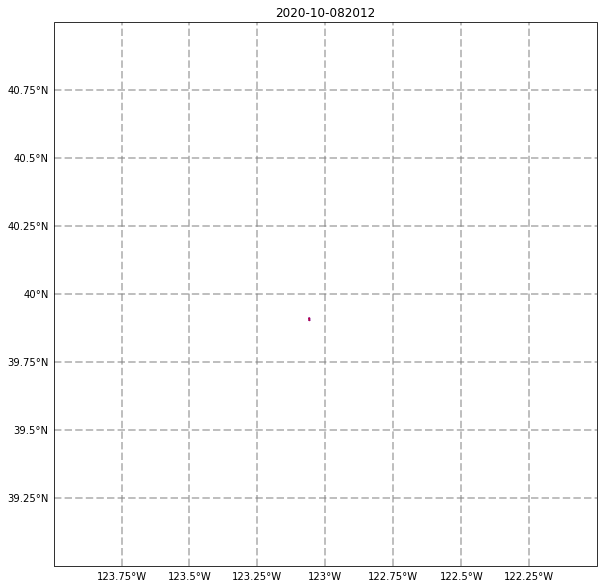

291
4 seconds
2020-10-08 2100
622
32
0 seconds


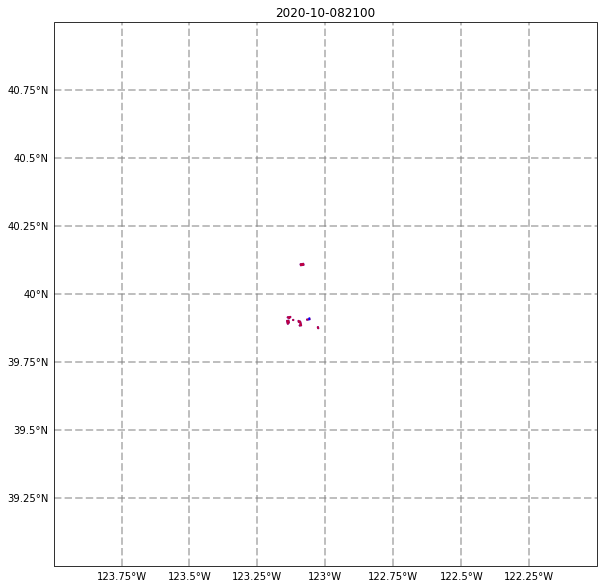

292
3 seconds
2020-10-08 2106
72
0
0 seconds
292
0 seconds
2020-10-08 2154
111
77
0 seconds


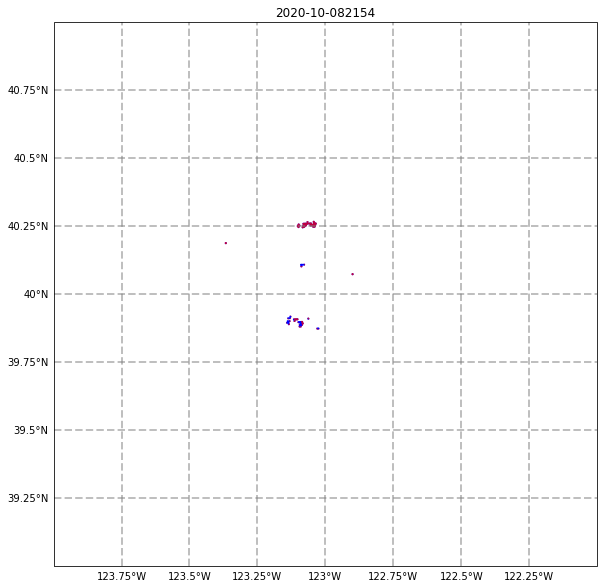

293
1 seconds
2020-10-09 736
13
0
0 seconds
293
0 seconds
2020-10-09 742
59
0
1 seconds
293
1 seconds
2020-10-09 830
471
0
0 seconds
293
0 seconds
2020-10-09 918
481
0
0 seconds
293
0 seconds
2020-10-09 924
506
181
0 seconds


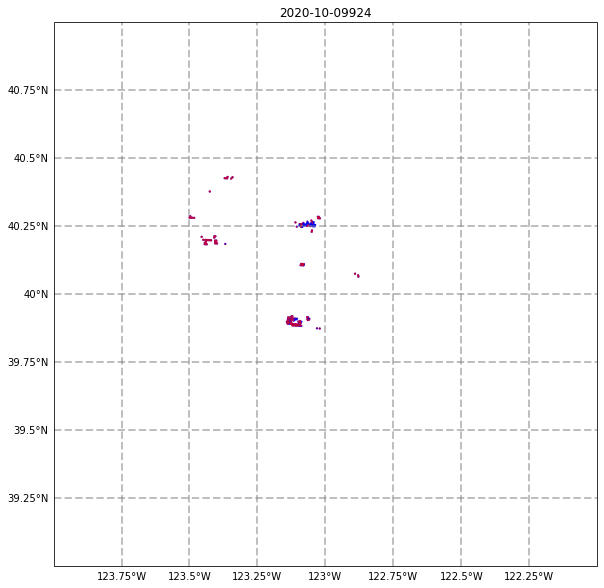

294
2 seconds
2020-10-09 1006
28
0
1 seconds
294
1 seconds
2020-10-09 1012
710
254
0 seconds


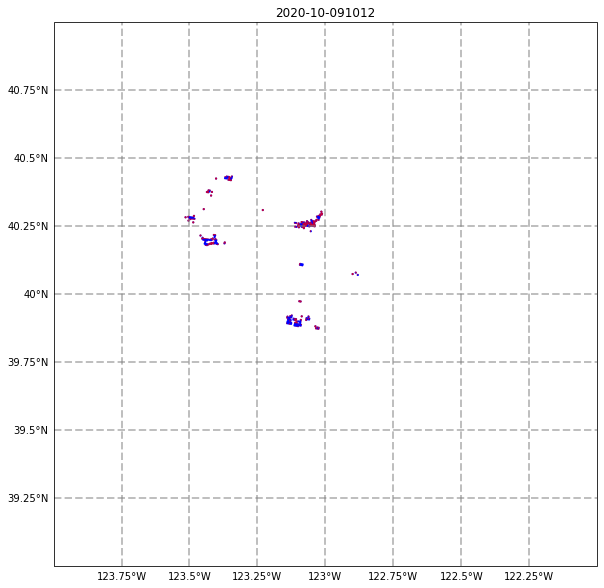

295
3 seconds
2020-10-09 1100
170
114
0 seconds


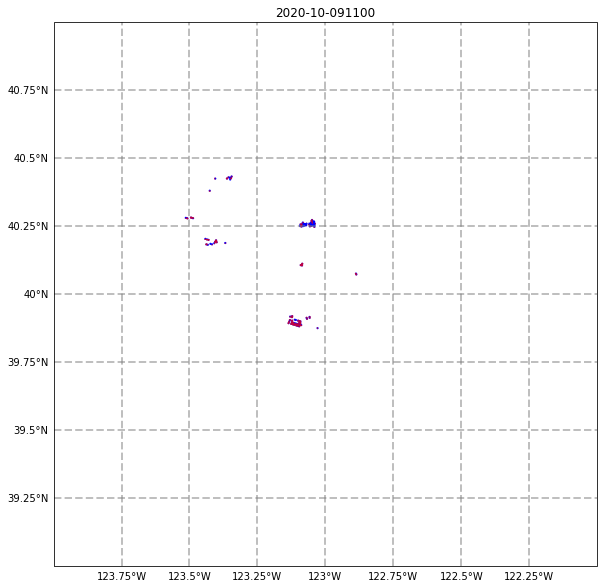

296
1 seconds
2020-10-09 1900
136
0
0 seconds
296
0 seconds
2020-10-09 1906
66
0
0 seconds
296
0 seconds
2020-10-09 1948
75
0
1 seconds
296
1 seconds
2020-10-09 1954
536
15
0 seconds


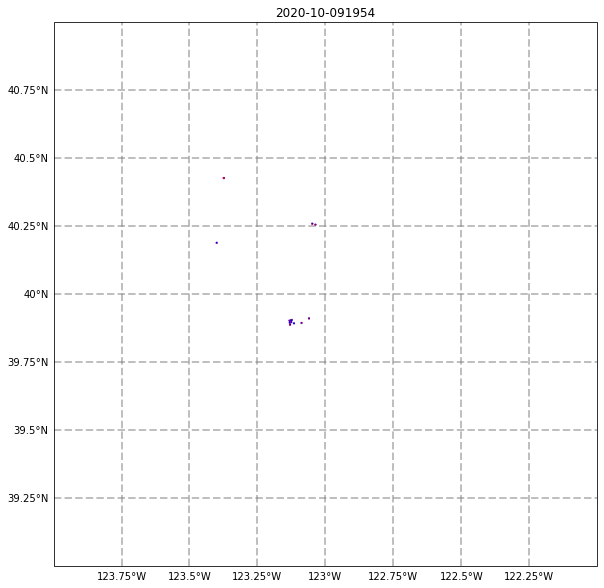

297
2 seconds
2020-10-09 2042
581
102
1 seconds


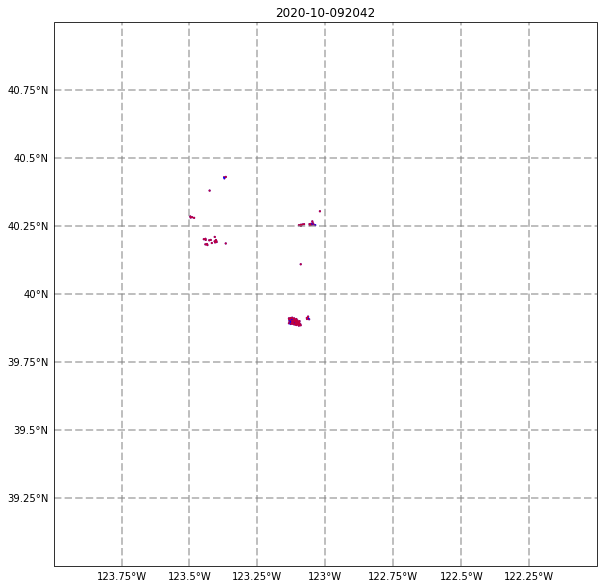

298
3 seconds
2020-10-09 2048
136
0
0 seconds
298
0 seconds
2020-10-09 2130
42
0
1 seconds
298
1 seconds
2020-10-09 2136
280
121
0 seconds


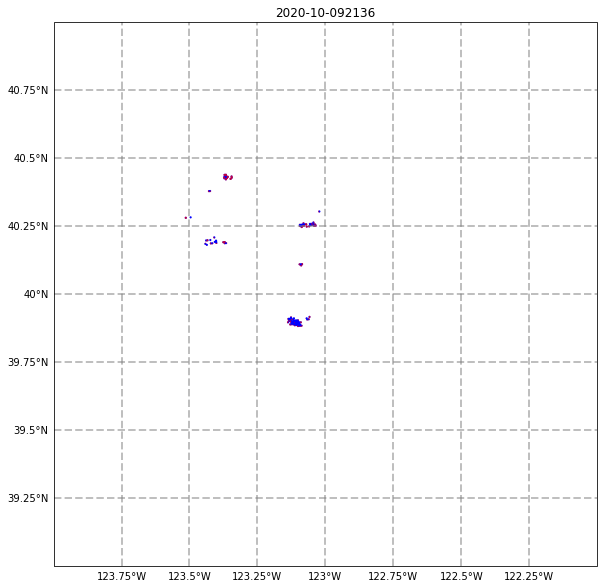

299
1 seconds
2020-10-10 806
11
0
1 seconds
299
1 seconds
2020-10-10 812
263
0
0 seconds
299
0 seconds
2020-10-10 900
481
0
0 seconds
299
0 seconds
2020-10-10 906
188
0
0 seconds
299
0 seconds
2020-10-10 948
176
0
0 seconds
299
0 seconds
2020-10-10 954
333
0
1 seconds
299
1 seconds
2020-10-10 1042
46
0
0 seconds
299
0 seconds
2020-10-10 1842
27
0
0 seconds
299
0 seconds
2020-10-10 1848
3
0
0 seconds
299
0 seconds
2020-10-10 1930
42
0
0 seconds
299
0 seconds
2020-10-10 1936
139
0
0 seconds
299
0 seconds
2020-10-10 2024
230
0
1 seconds
299
1 seconds
2020-10-10 2030
2
0
0 seconds
299
0 seconds
2020-10-10 2112
158
0
0 seconds
299
0 seconds
2020-10-10 2118
9
0
0 seconds
299
0 seconds
2020-10-10 2206
1
0
0 seconds
299
0 seconds
2020-10-11 748
20
0
1 seconds
299
1 seconds
2020-10-11 754
158
0
0 seconds
299
0 seconds
2020-10-11 842
419
0
0 seconds
299
0 seconds
2020-10-11 848
40
0
0 seconds
299
0 seconds
2020-10-11 930
139
2
0 seconds


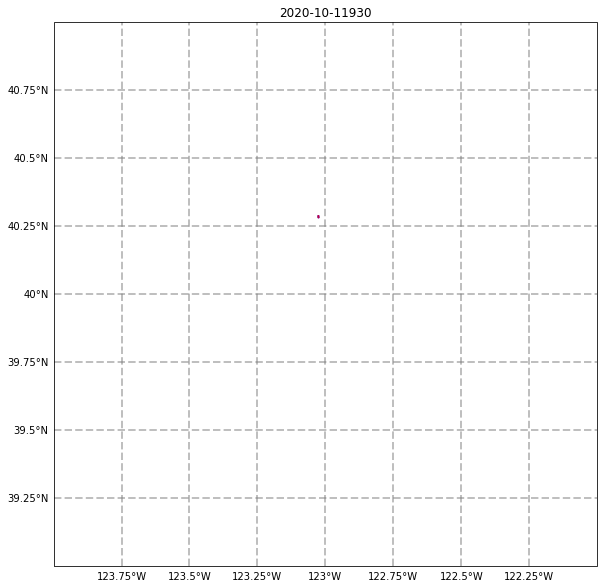

300
1 seconds
2020-10-11 936
316
0
0 seconds
300
0 seconds
2020-10-11 1024
118
4
1 seconds


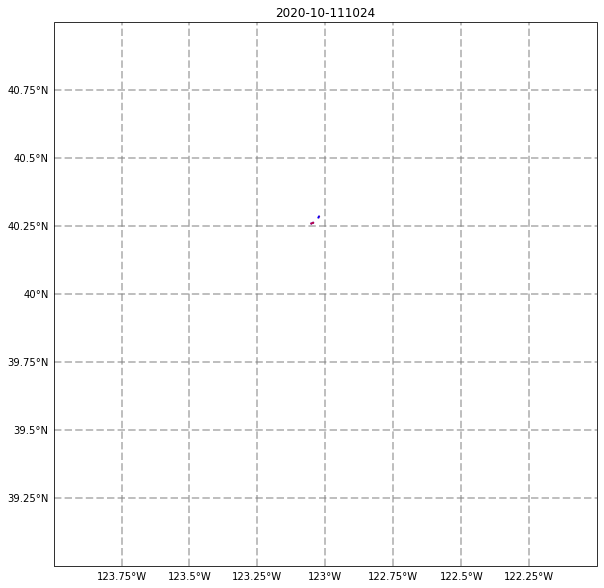

301
1 seconds
2020-10-11 1112
2
1
0 seconds


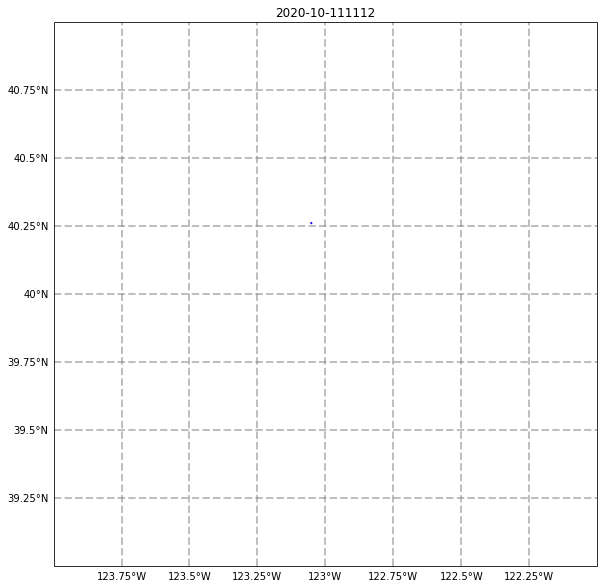

302
1 seconds
2020-10-11 1912
21
0
0 seconds
302
0 seconds
2020-10-11 1918
1
0
0 seconds
302
0 seconds
2020-10-11 2000
6
0
0 seconds
302
0 seconds
2020-10-11 2006
75
2
0 seconds


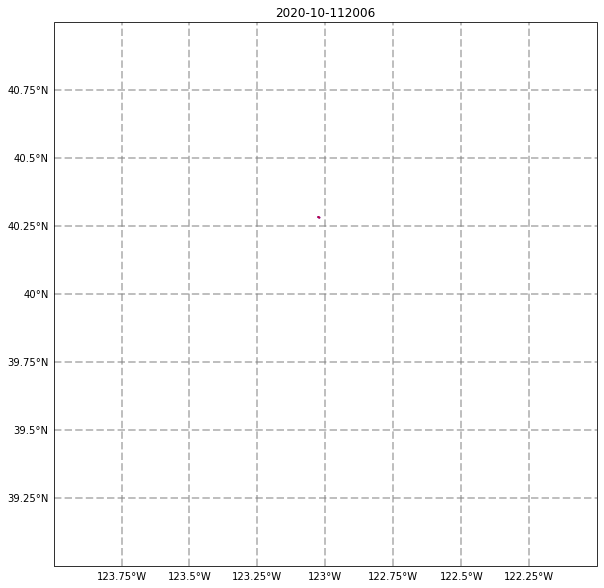

303
1 seconds
2020-10-11 2054
129
1
0 seconds


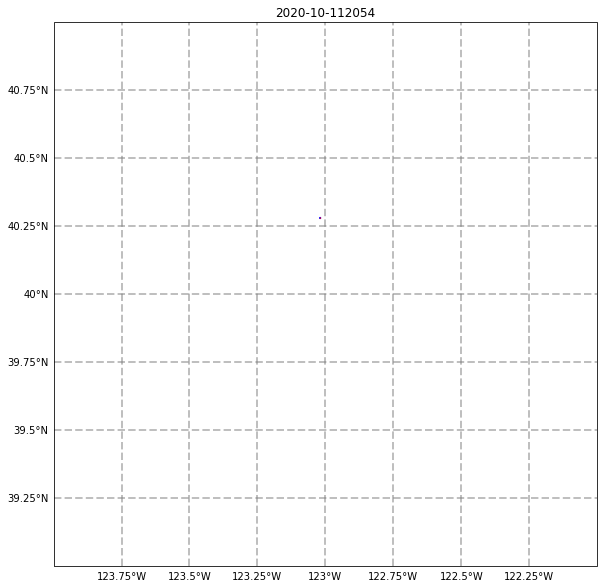

304
1 seconds
2020-10-11 2100
2
0
0 seconds
304
0 seconds
2020-10-11 2148
57
1
0 seconds


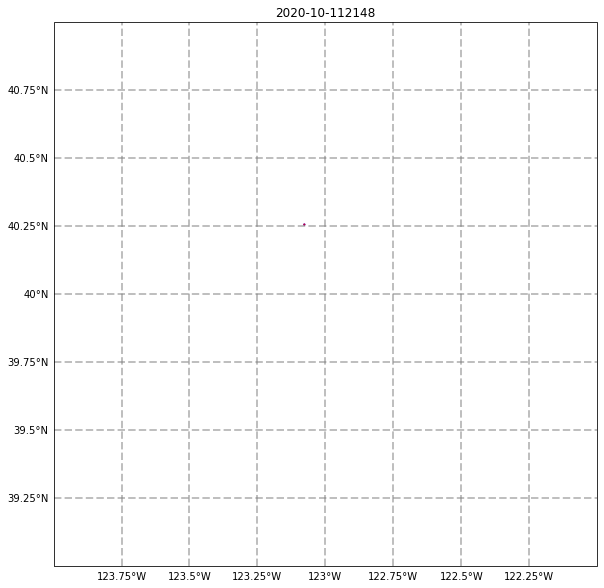

305
0 seconds
2020-10-12 730
10
0
0 seconds
305
0 seconds
2020-10-12 736
22
0
1 seconds
305
1 seconds
2020-10-12 824
99
0
0 seconds
305
0 seconds
2020-10-12 912
147
3
0 seconds


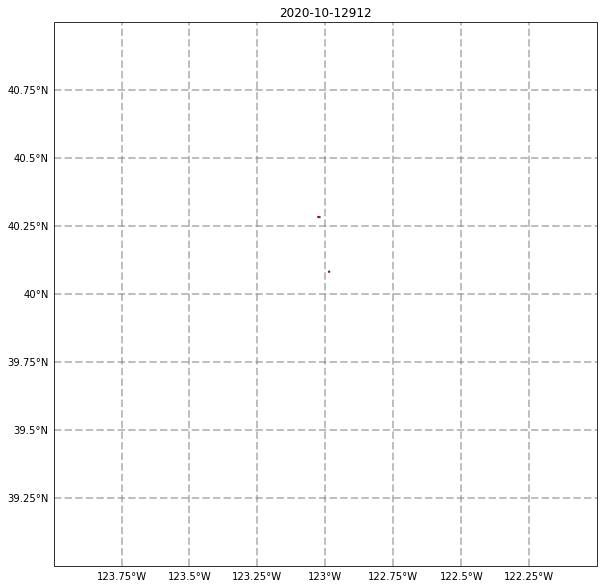

306
1 seconds
2020-10-12 918
131
0
0 seconds
306
0 seconds
2020-10-12 1000
17
0
0 seconds
306
0 seconds
2020-10-12 1006
201
10
0 seconds


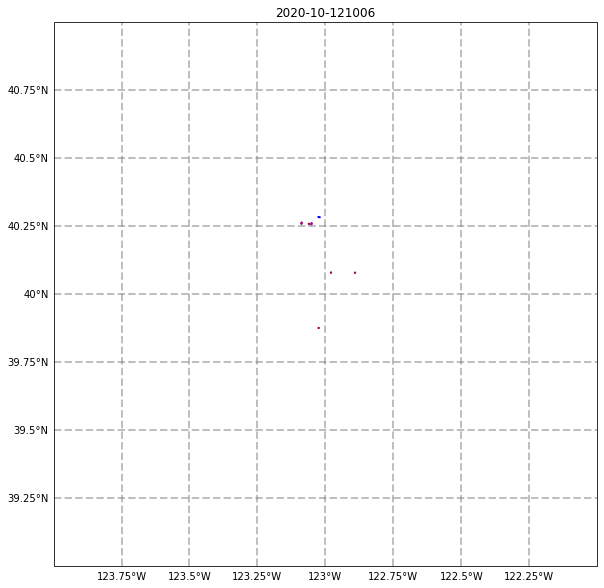

307
1 seconds
2020-10-12 1054
59
2
1 seconds


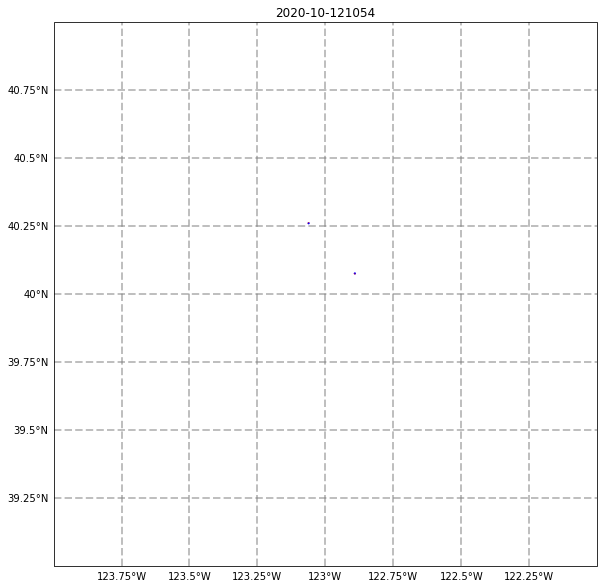

308
1 seconds
2020-10-12 1854
9
0
0 seconds
308
0 seconds
2020-10-12 1942
36
0
0 seconds
308
0 seconds
2020-10-12 1948
73
0
0 seconds
308
0 seconds
2020-10-12 2036
233
1
1 seconds


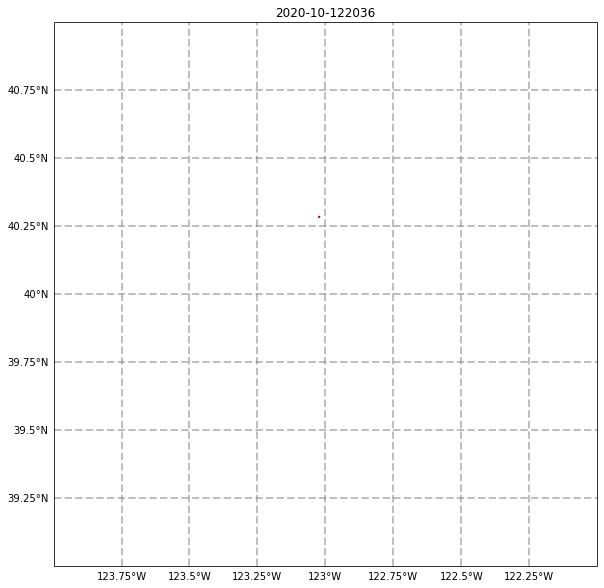

309
2 seconds
2020-10-12 2124
163
0
0 seconds
309
0 seconds
2020-10-12 2130
61
1
0 seconds


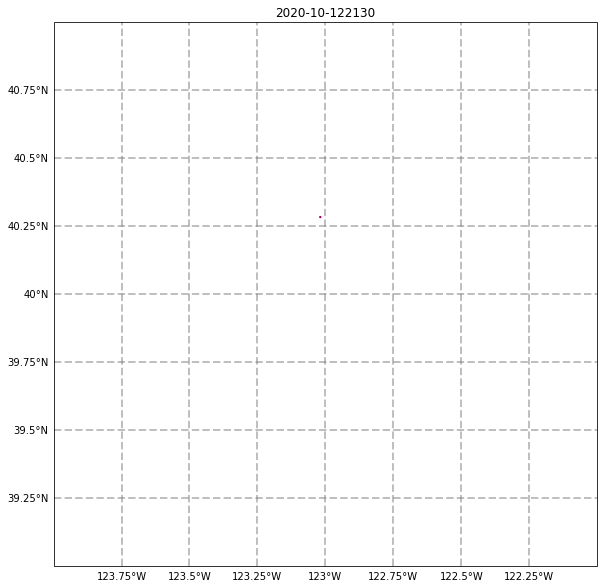

310
1 seconds
2020-10-12 2218
4
0
0 seconds
310
0 seconds
2020-10-13 800
13
0
0 seconds
310
0 seconds
2020-10-13 806
77
0
0 seconds
310
0 seconds
2020-10-13 854
280
1
0 seconds


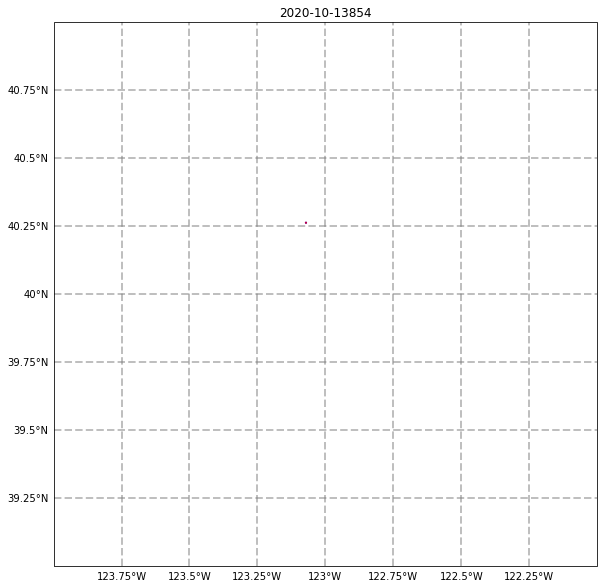

311
2 seconds
2020-10-13 900
10
0
0 seconds
311
0 seconds
2020-10-13 942
2
0
0 seconds
311
0 seconds
2020-10-13 948
450
7
0 seconds


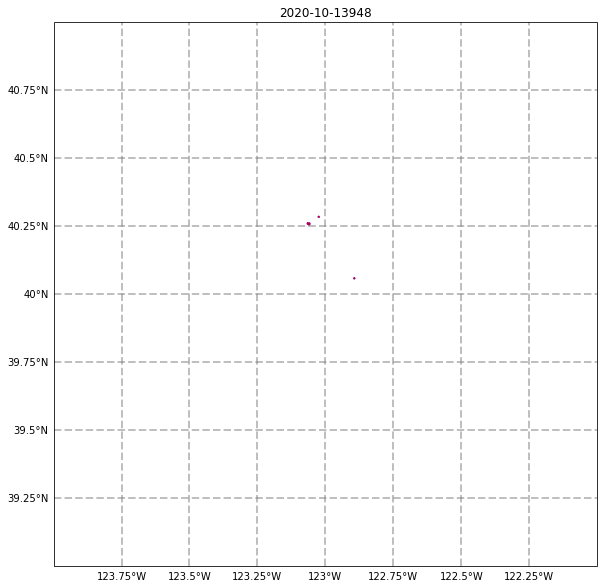

312
2 seconds
2020-10-13 1036
150
3
0 seconds


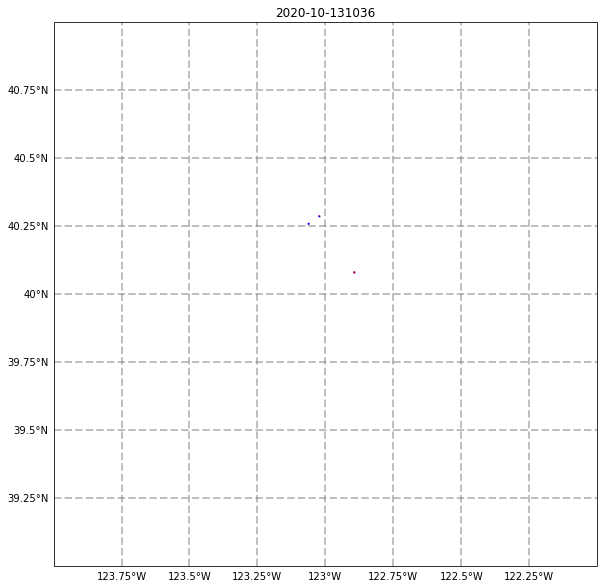

313
1 seconds
2020-10-13 1836
1
0
0 seconds
313
0 seconds
2020-10-13 1924
17
0
1 seconds
313
1 seconds
2020-10-13 1930
23
0
0 seconds
313
0 seconds
2020-10-13 2012
4
0
0 seconds
313
0 seconds
2020-10-13 2018
180
1
0 seconds


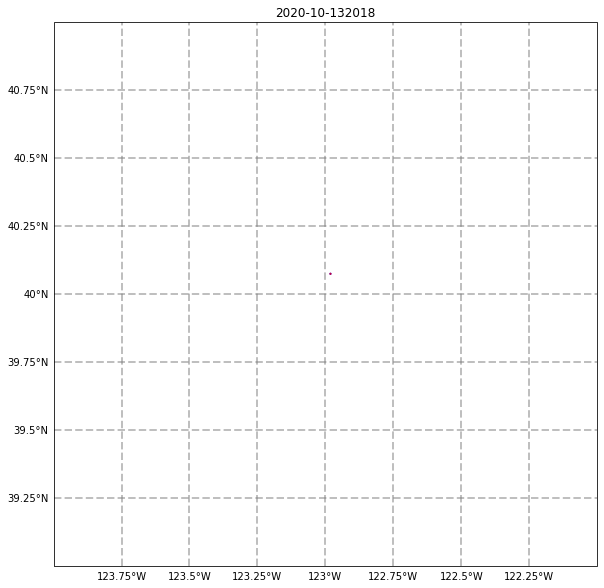

314
1 seconds
2020-10-13 2106
190
3
0 seconds


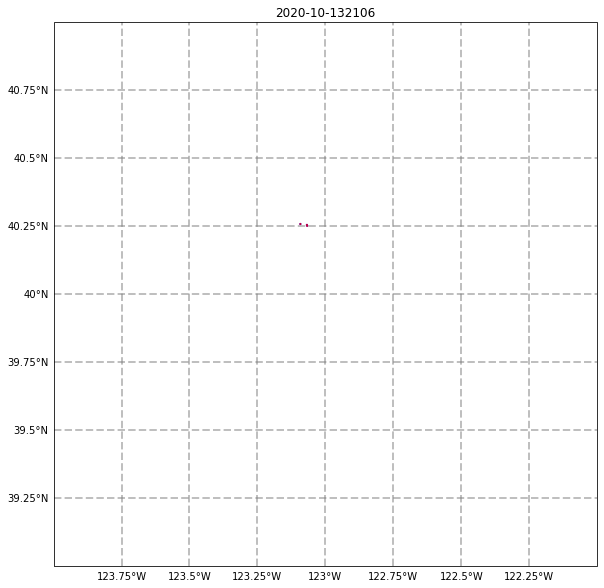

315
1 seconds
2020-10-13 2112
11
0
0 seconds
315
0 seconds
2020-10-13 2200
78
0
1 seconds
315
1 seconds
2020-10-14 748
229
0
0 seconds
315
0 seconds
2020-10-14 836
401
0
0 seconds
315
0 seconds
2020-10-14 924
305
0
0 seconds
315
0 seconds
2020-10-14 930
372
3
0 seconds


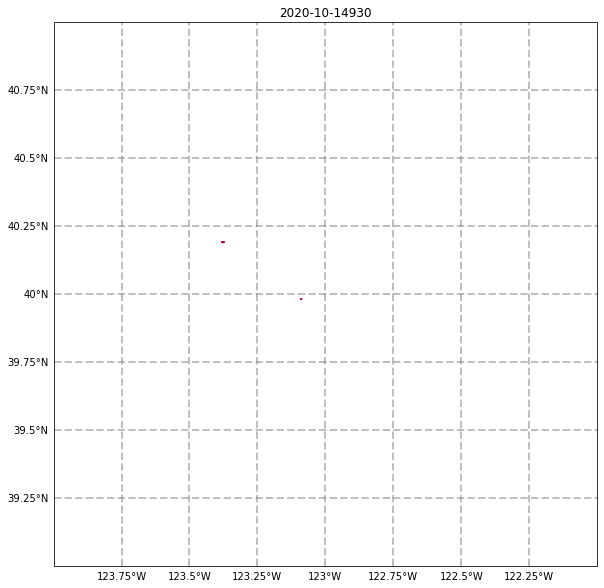

316
2 seconds
2020-10-14 1012
5
0
0 seconds
316
0 seconds
2020-10-14 1018
264
18
0 seconds


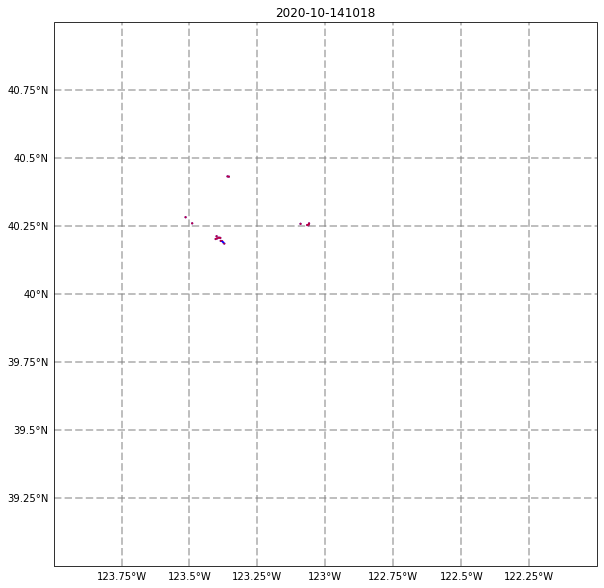

317
2 seconds
2020-10-14 1106
8
2
0 seconds


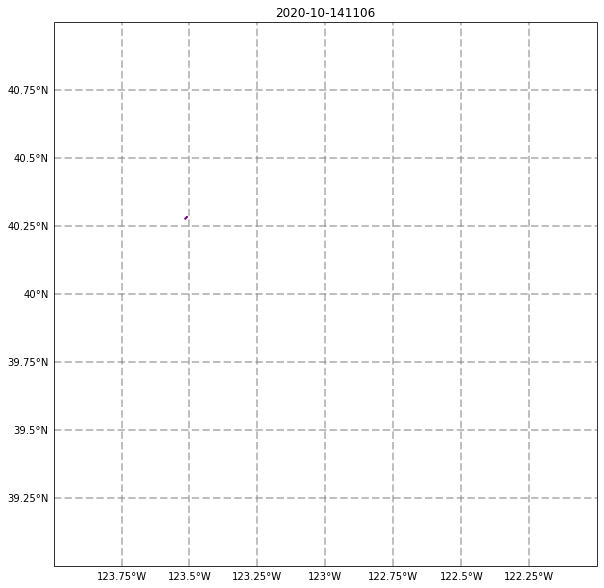

318
0 seconds
2020-10-14 1906
297
0
0 seconds
318
0 seconds
2020-10-14 1912
270
0
0 seconds
318
0 seconds
2020-10-14 1954
62
0
0 seconds
318
0 seconds
2020-10-14 2000
575
0
1 seconds
318
1 seconds
2020-10-14 2048
709
12
0 seconds


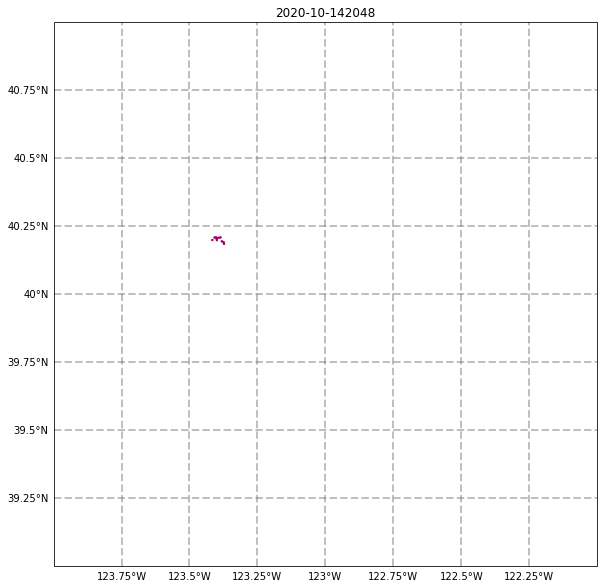

319
3 seconds
2020-10-14 2054
41
0
0 seconds
319
0 seconds
2020-10-14 2136
198
0
0 seconds
319
0 seconds
2020-10-14 2142
38
10
0 seconds


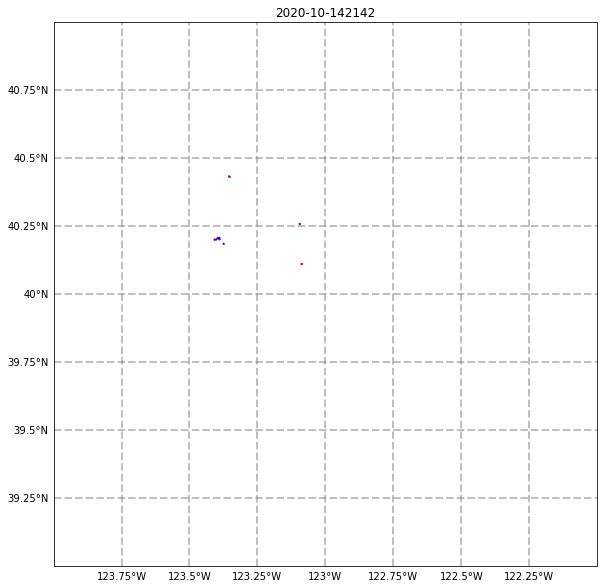

320
1 seconds
2020-10-15 730
18
0
0 seconds
320
0 seconds
2020-10-15 812
21
0
0 seconds
320
0 seconds
2020-10-15 818
160
0
0 seconds
320
0 seconds
2020-10-15 906
317
25
1 seconds


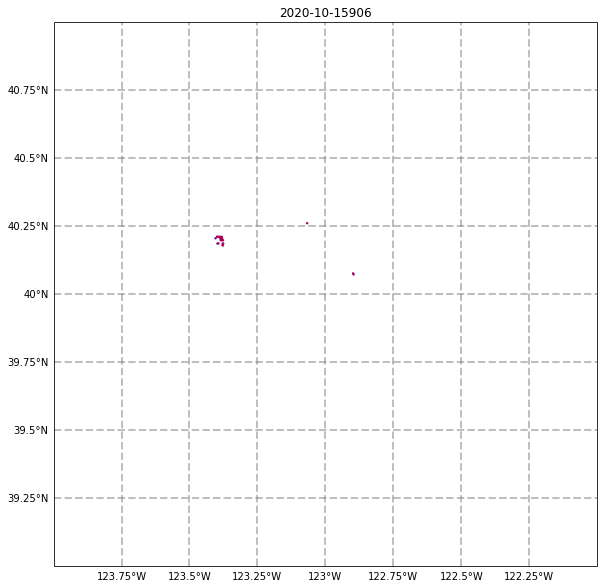

321
2 seconds
2020-10-15 912
321
0
0 seconds
321
0 seconds
2020-10-15 954
47
0
0 seconds
321
0 seconds
2020-10-15 1000
592
67
1 seconds


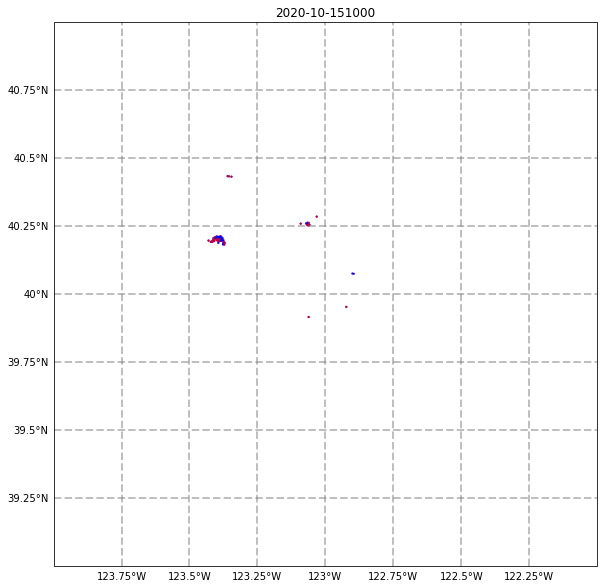

322
3 seconds
2020-10-15 1048
245
34
1 seconds


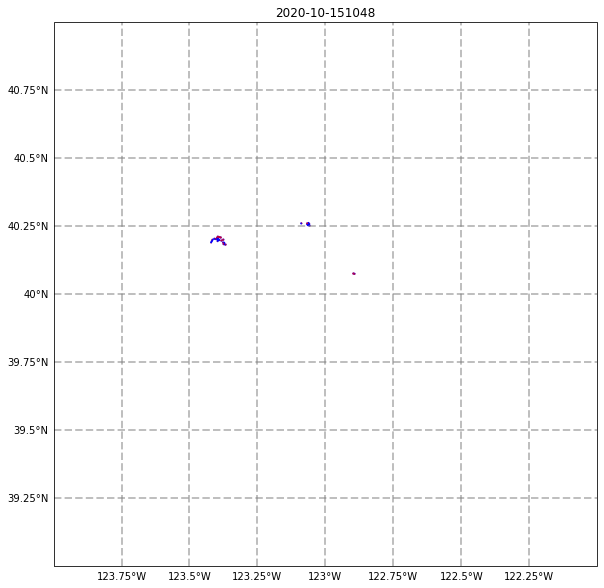

323
2 seconds
2020-10-15 1136
3
0
0 seconds
323
0 seconds
2020-10-15 1848
67
0
0 seconds
323
0 seconds
2020-10-15 1936
19
0
0 seconds
323
0 seconds
2020-10-15 1942
174
0
1 seconds
323
1 seconds
2020-10-15 2030
490
34
0 seconds


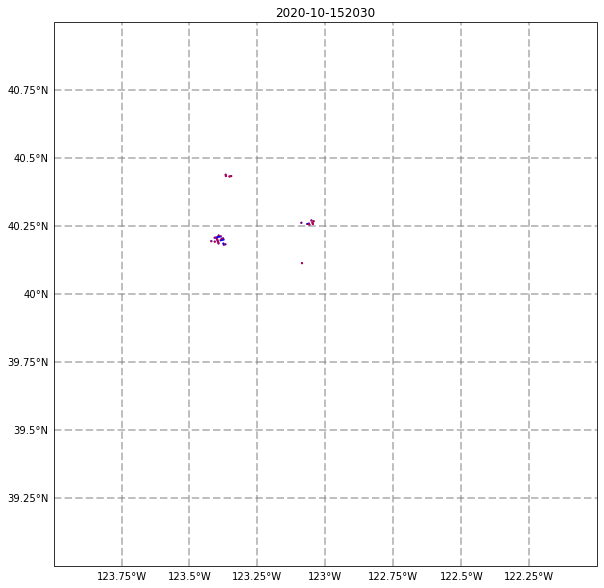

324
2 seconds
2020-10-15 2036
17
0
0 seconds
324
0 seconds
2020-10-15 2118
263
48
0 seconds


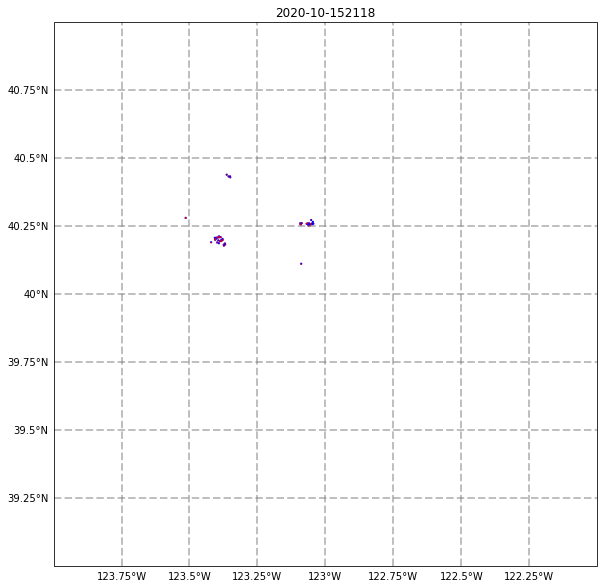

325
2 seconds
2020-10-15 2124
60
0
0 seconds
325
0 seconds
2020-10-15 2212
26
22
0 seconds


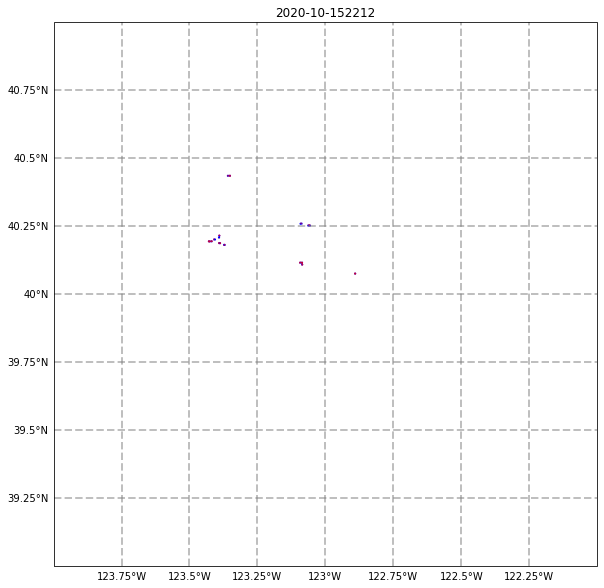

326
0 seconds
2020-10-16 754
19
0
1 seconds
326
1 seconds
2020-10-16 800
132
0
0 seconds
326
0 seconds
2020-10-16 848
400
0
0 seconds
326
0 seconds
2020-10-16 854
78
0
0 seconds
326
0 seconds
2020-10-16 936
77
0
0 seconds
326
0 seconds
2020-10-16 942
693
66
0 seconds


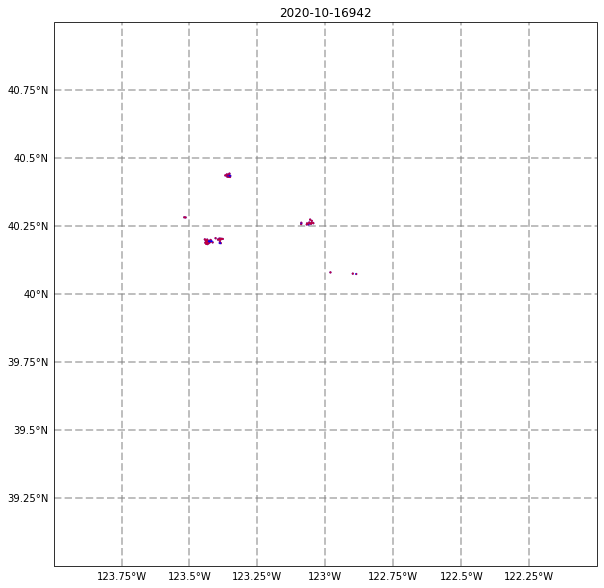

327
3 seconds
2020-10-16 1030
355
44
1 seconds


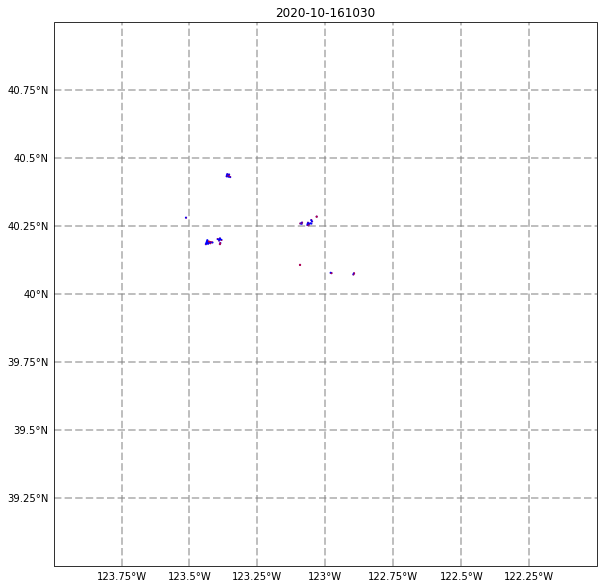

328
2 seconds
2020-10-16 1118
10
3
1 seconds


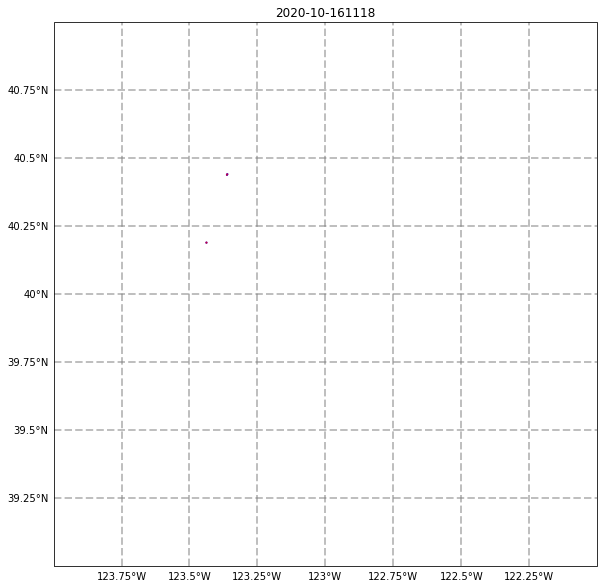

329
1 seconds
2020-10-16 1836
3
0
0 seconds
329
0 seconds
2020-10-16 1918
201
0
0 seconds
329
0 seconds
2020-10-16 1924
18
0
0 seconds
329
0 seconds
2020-10-16 2006
1
0
1 seconds
329
1 seconds
2020-10-16 2012
465
4
0 seconds


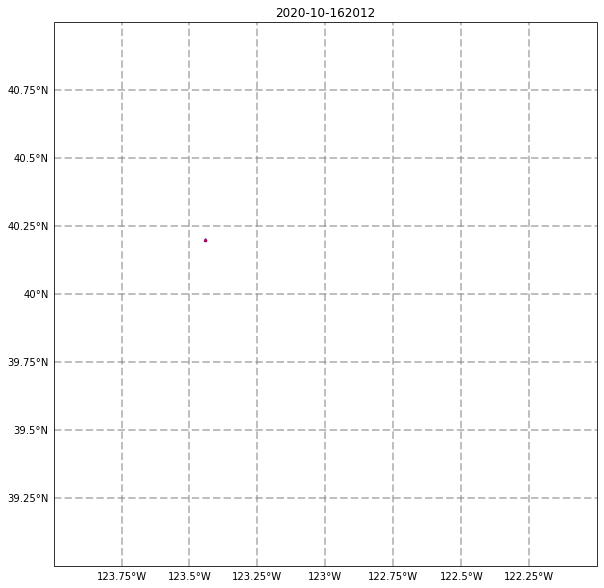

330
2 seconds
2020-10-16 2100
525
12
0 seconds


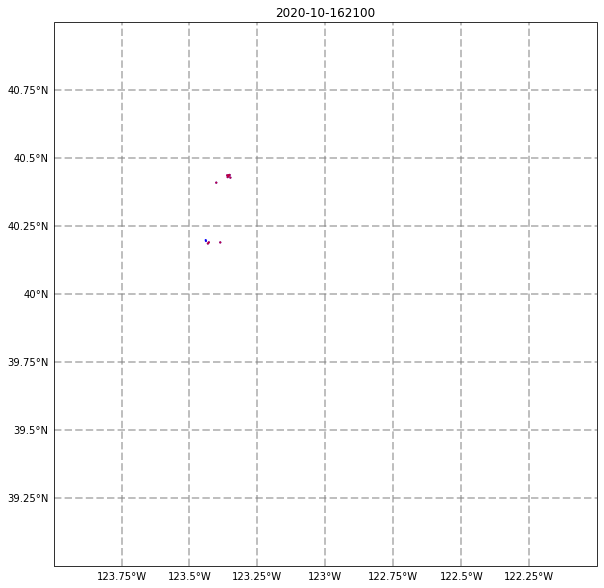

331
2 seconds
2020-10-16 2106
24
0
1 seconds
331
1 seconds
2020-10-16 2154
202
16
0 seconds


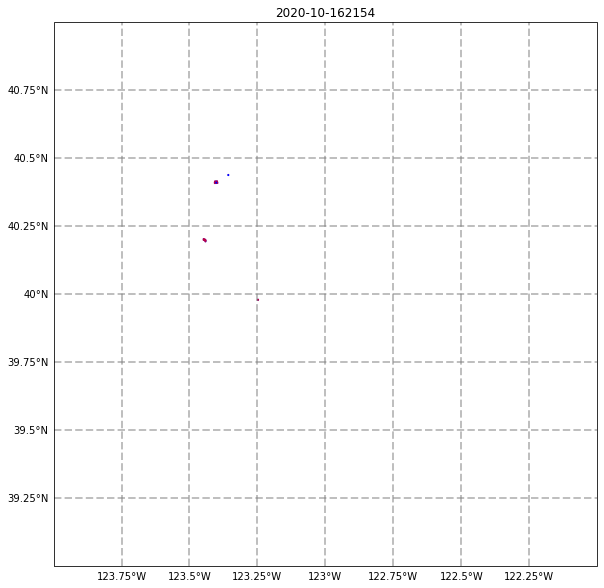

332
1 seconds
2020-10-17 742
48
0
0 seconds
332
0 seconds
2020-10-17 830
1284
0
0 seconds
332
0 seconds
2020-10-17 918
700
3
0 seconds


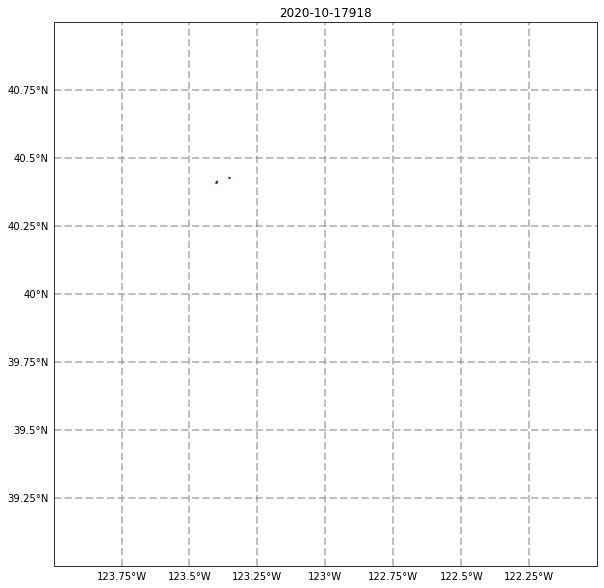

333
4 seconds
2020-10-17 924
376
0
0 seconds
333
0 seconds
2020-10-17 1012
461
17
0 seconds


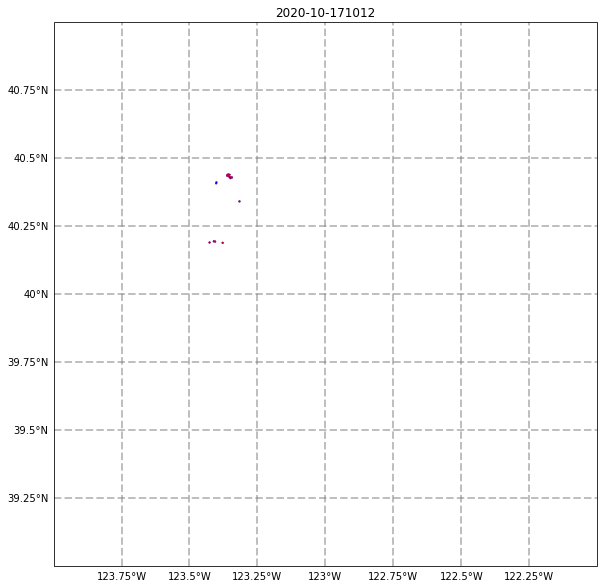

334
2 seconds
2020-10-17 1100
26
1
0 seconds


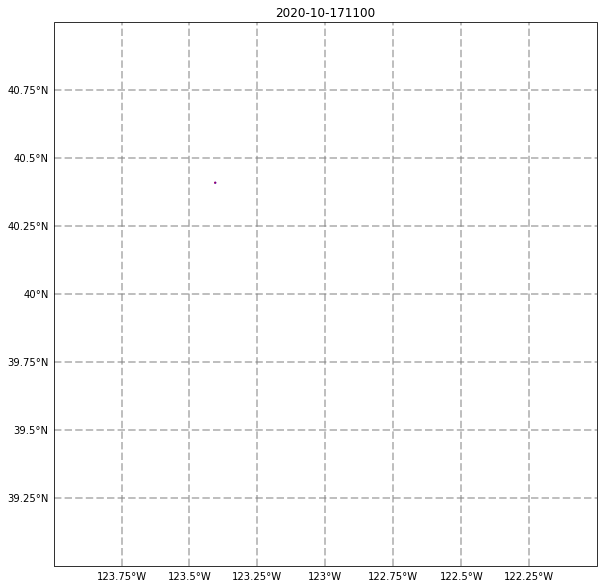

335
1 seconds
2020-10-17 1812
1
0
0 seconds
335
0 seconds
2020-10-17 1900
46
0
0 seconds
335
0 seconds
2020-10-17 1906
1
0
0 seconds
335
0 seconds
2020-10-17 1948
18
0
0 seconds
335
0 seconds
2020-10-17 1954
365
0
1 seconds
335
1 seconds
2020-10-17 2042
413
0
0 seconds
335
0 seconds
2020-10-17 2130
38
0
0 seconds
335
0 seconds
2020-10-17 2136
118
1
0 seconds


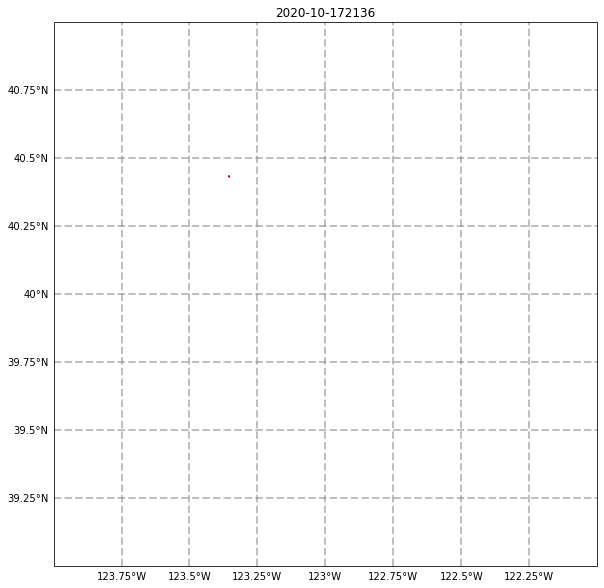

336
1 seconds
2020-10-18 812
307
0
0 seconds
336
0 seconds
2020-10-18 900
475
1
0 seconds


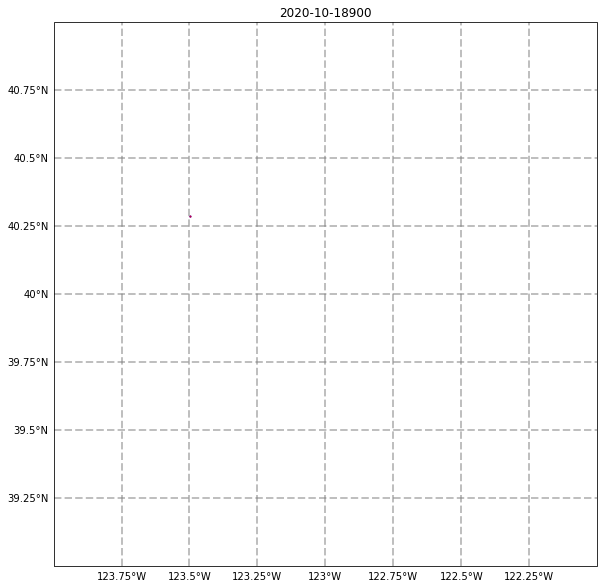

337
2 seconds
2020-10-18 906
63
0
0 seconds
337
0 seconds
2020-10-18 954
547
12
1 seconds


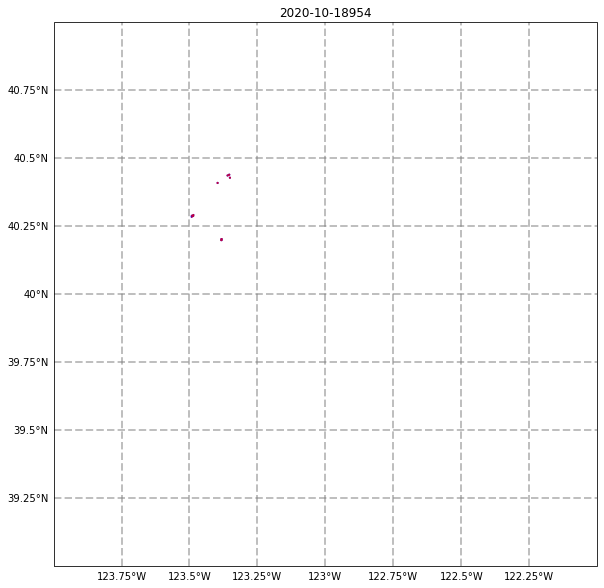

338
3 seconds
2020-10-18 1042
131
3
0 seconds


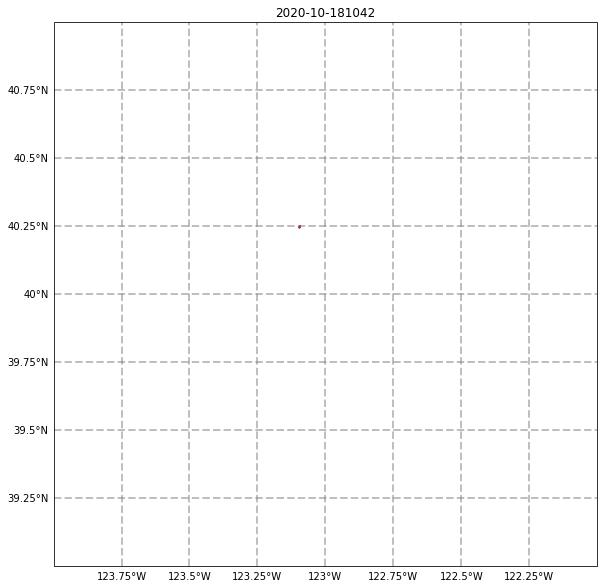

339
1 seconds
2020-10-18 1842
1
0
0 seconds
339
0 seconds
2020-10-18 1930
113
0
0 seconds
339
0 seconds
2020-10-18 1936
95
0
1 seconds
339
1 seconds
2020-10-18 2018
6
0
0 seconds
339
0 seconds
2020-10-18 2024
321
0
0 seconds
339
0 seconds
2020-10-18 2112
195
0
0 seconds
339
0 seconds
2020-10-18 2118
14
1
0 seconds


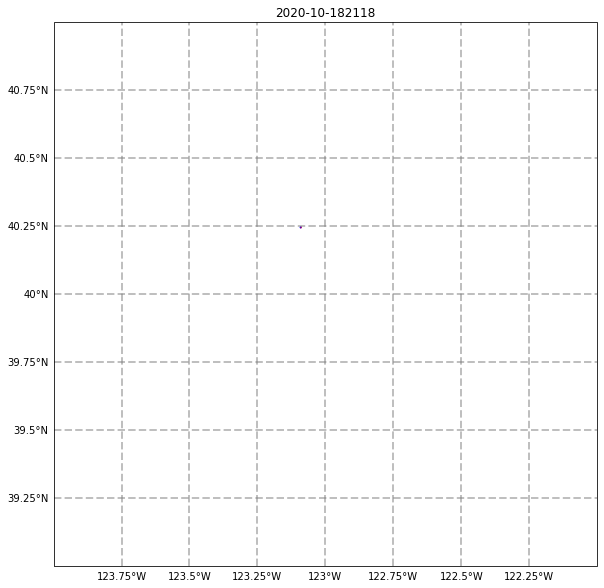

340
0 seconds
2020-10-18 2206
18
0
1 seconds
340
1 seconds
2020-10-19 754
152
0
0 seconds
340
0 seconds
2020-10-19 842
633
0
0 seconds
340
0 seconds
2020-10-19 930
39
0
0 seconds
340
0 seconds
2020-10-19 936
569
1
0 seconds


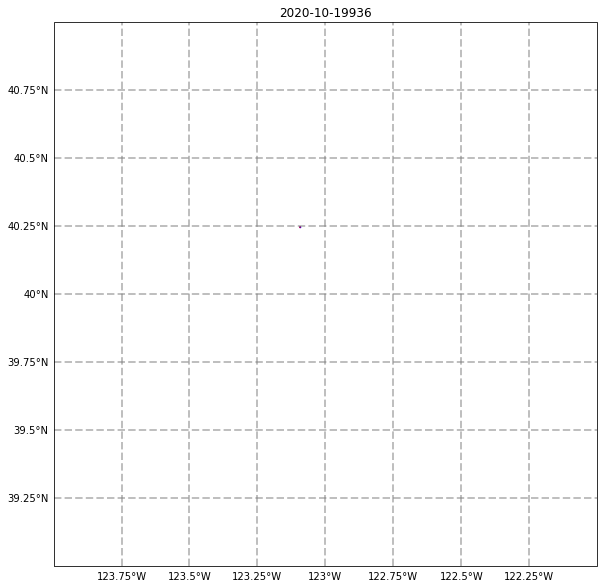

341
3 seconds
2020-10-19 1024
210
3
0 seconds


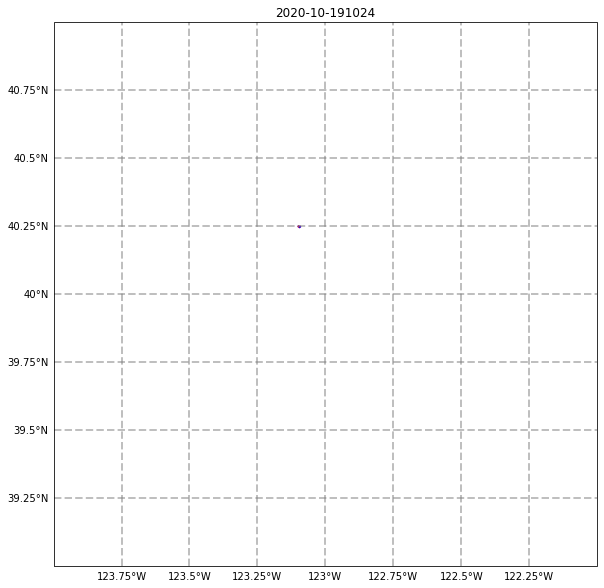

342
1 seconds
2020-10-19 1824
9
0
1 seconds
342
1 seconds
2020-10-19 1912
69
0
0 seconds
342
0 seconds
2020-10-19 1918
34
0
0 seconds
342
0 seconds
2020-10-19 2000
27
0
0 seconds
342
0 seconds
2020-10-19 2006
355
0
0 seconds
342
0 seconds
2020-10-19 2054
371
1
0 seconds


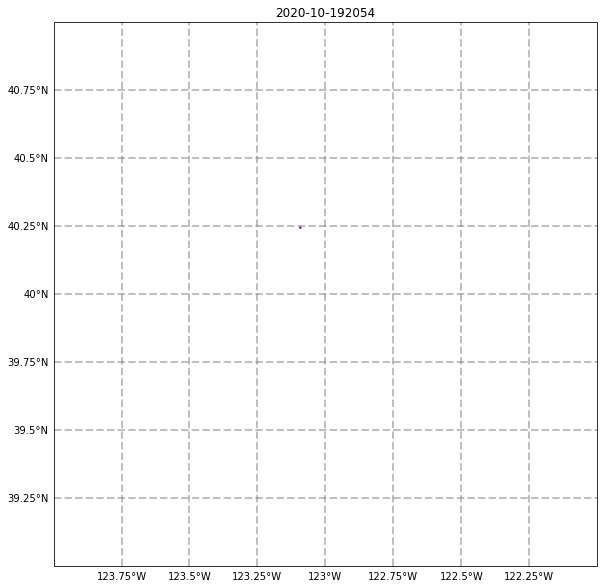

343
2 seconds
2020-10-19 2100
32
0
0 seconds
343
0 seconds
2020-10-19 2142
19
0
1 seconds
343
1 seconds
2020-10-19 2148
176
1
0 seconds


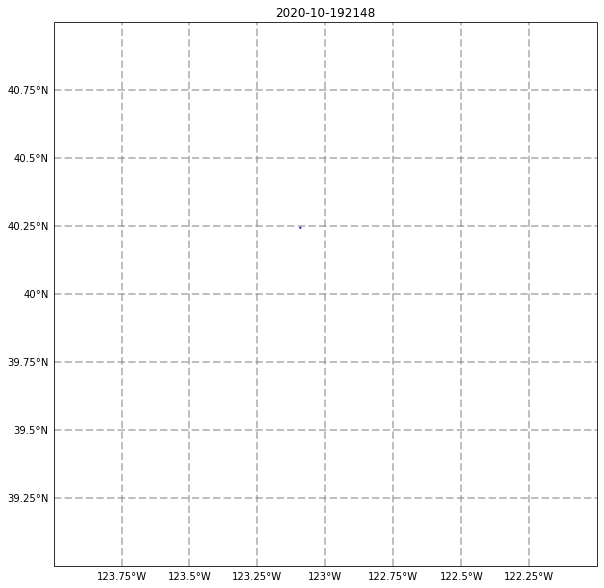

344
1 seconds
2020-10-20 736
23
0
0 seconds
344
0 seconds
2020-10-20 818
3
0
0 seconds
344
0 seconds
2020-10-20 824
281
0
0 seconds
344
0 seconds
2020-10-20 912
341
1
0 seconds


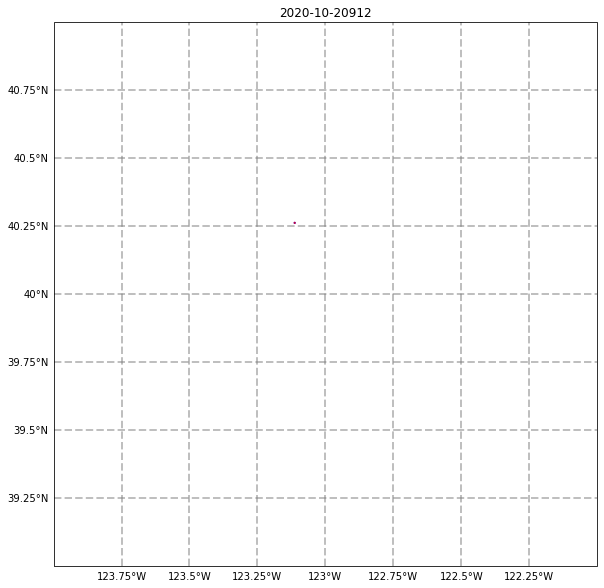

345
2 seconds
2020-10-20 918
310
0
0 seconds
345
0 seconds
2020-10-20 1000
41
0
0 seconds
345
0 seconds
2020-10-20 1006
443
3
1 seconds


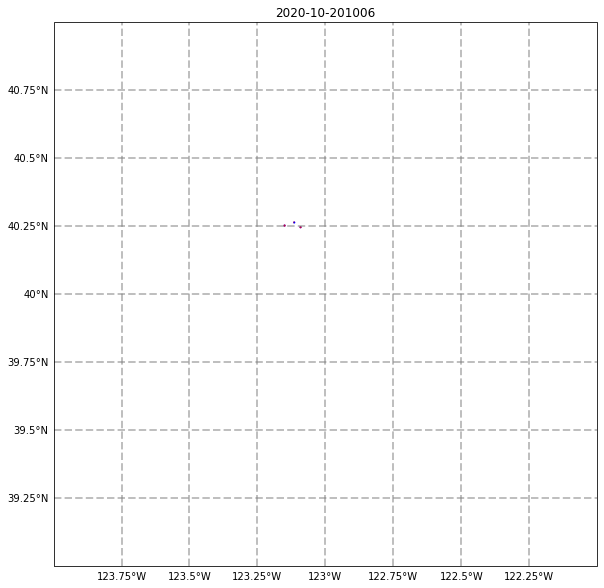

346
3 seconds
2020-10-20 1054
103
0
0 seconds
346
0 seconds
2020-10-20 1142
1
0
0 seconds
346
0 seconds
2020-10-20 1854
23
0
0 seconds
346
0 seconds
2020-10-20 1900
2
0
0 seconds
346
0 seconds
2020-10-20 1942
70
0
0 seconds
346
0 seconds
2020-10-20 1948
119
0
1 seconds
346
1 seconds
2020-10-20 2036
366
1
0 seconds


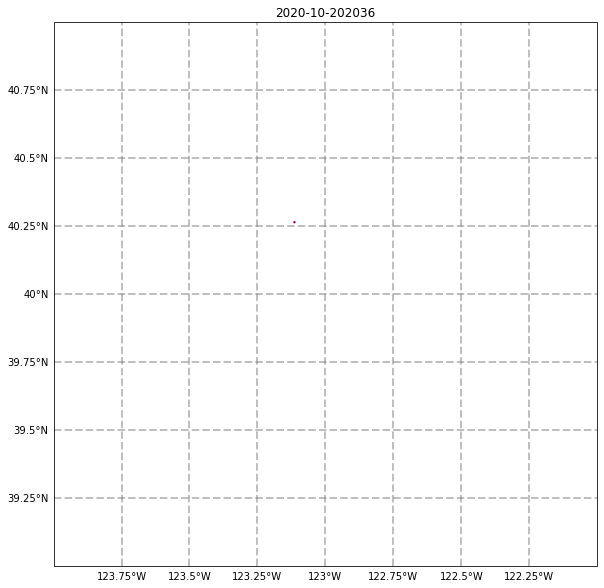

347
2 seconds
2020-10-20 2042
48
0
0 seconds
347
0 seconds
2020-10-20 2124
181
0
0 seconds
347
0 seconds
2020-10-20 2130
97
0
0 seconds
347
0 seconds
2020-10-21 800
1
0
0 seconds
347
0 seconds
2020-10-21 806
191
0
1 seconds
347
1 seconds
2020-10-21 854
435
0
0 seconds
347
0 seconds
2020-10-21 900
71
0
0 seconds
347
0 seconds
2020-10-21 942
141
0
0 seconds
347
0 seconds
2020-10-21 948
456
0
0 seconds
347
0 seconds
2020-10-21 1036
214
0
0 seconds
347
0 seconds
2020-10-21 1124
4
0
1 seconds
347
1 seconds
2020-10-21 1836
2
0
0 seconds
347
0 seconds
2020-10-21 1842
4
0
0 seconds
347
0 seconds
2020-10-21 1924
53
0
0 seconds
347
0 seconds
2020-10-21 1930
253
0
0 seconds
347
0 seconds
2020-10-21 2018
567
0
0 seconds
347
0 seconds
2020-10-21 2024
6
0
1 seconds
347
1 seconds
2020-10-21 2106
374
0
0 seconds
347
0 seconds
2020-10-21 2112
98
0
0 seconds
347
0 seconds
2020-10-21 2200
196
0
0 seconds
347
0 seconds
2020-10-22 748
710
0
0 seconds
347
0 seconds
2020-10-22 836
2116
0
1 seconds
347
1 seco

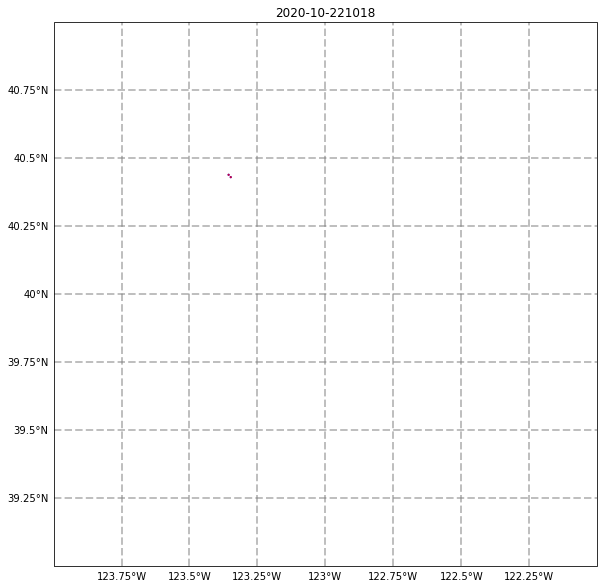

348
2 seconds
2020-10-22 1106
30
0
0 seconds
348
0 seconds
2020-10-22 1906
570
0
0 seconds
348
0 seconds
2020-10-22 1912
17
0
0 seconds
348
0 seconds
2020-10-22 1954
10
0
0 seconds
348
0 seconds
2020-10-22 2000
1112
0
0 seconds
348
0 seconds
2020-10-22 2048
1038
0
1 seconds
348
1 seconds
2020-10-22 2054
35
0
0 seconds
348
0 seconds
2020-10-22 2136
5
0
0 seconds
348
0 seconds
2020-10-22 2142
158
0
0 seconds
348
0 seconds
2020-10-23 730
16
0
0 seconds
348
0 seconds
2020-10-23 818
201
0
1 seconds
348
1 seconds
2020-10-23 906
405
0
0 seconds
348
0 seconds
2020-10-23 912
57
0
0 seconds
348
0 seconds
2020-10-23 954
55
0
0 seconds
348
0 seconds
2020-10-23 1000
370
0
0 seconds
348
0 seconds
2020-10-23 1048
107
0
0 seconds
348
0 seconds
2020-10-23 1848
7
0
1 seconds
348
1 seconds
2020-10-23 1854
2
0
0 seconds
348
0 seconds
2020-10-23 1936
5
0
0 seconds
348
0 seconds
2020-10-23 1942
33
0
0 seconds
348
0 seconds
2020-10-23 2030
180
0
0 seconds
348
0 seconds
2020-10-23 2118
110
0
0 seconds
348
0 s

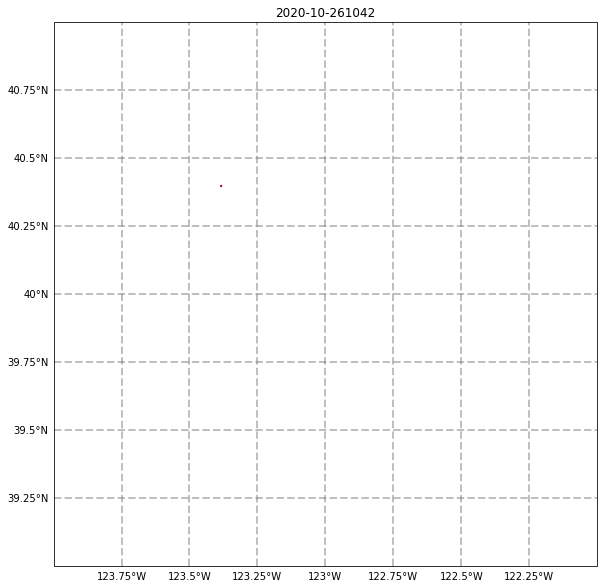

349
1 seconds
2020-10-26 1930
2
0
0 seconds
349
0 seconds
2020-10-26 1936
23
0
0 seconds
349
0 seconds
2020-10-26 2024
510
0
0 seconds
349
0 seconds
2020-10-26 2030
1
0
0 seconds
349
0 seconds
2020-10-26 2112
425
0
0 seconds
349
0 seconds
2020-10-26 2118
23
0
1 seconds
349
1 seconds
2020-10-26 2206
13
0
0 seconds
349
0 seconds
2020-10-27 748
2
0
0 seconds
349
0 seconds
2020-10-27 842
204
0
0 seconds
349
0 seconds
2020-10-27 848
6
0
0 seconds
349
0 seconds
2020-10-27 930
50
0
1 seconds
349
1 seconds
2020-10-27 936
561
0
0 seconds
349
0 seconds
2020-10-27 1024
431
0
0 seconds
349
0 seconds
2020-10-27 1112
7
0
0 seconds
349
0 seconds
2020-10-27 1912
1
0
0 seconds
349
0 seconds
2020-10-27 1918
26
0
0 seconds
349
0 seconds
2020-10-27 2006
247
0
1 seconds
349
1 seconds
2020-10-27 2054
282
0
0 seconds
349
0 seconds
2020-10-27 2100
54
0
0 seconds
349
0 seconds
2020-10-27 2142
32
0
0 seconds
349
0 seconds
2020-10-27 2148
114
0
0 seconds
349
0 seconds
2020-10-28 736
2
0
0 seconds
349
0 seconds
2

,Incident Number,Fire Name,Current Day,Current Overpass,Lat Fire,Lon Fire,Number of NEW VIIRS points,NEW FRP,geometry
0,11843929.0,AUGUST COMPLEX,2020-08-18,800.0,39.659444,-122.808889,0.0,0.00,"POLYGON ((-122.80489 39.65944, -122.80491 39.6..."
1,11843929.0,AUGUST COMPLEX,2020-08-18,854.0,39.659444,-122.808889,12.0,41.89,"MULTIPOLYGON (((-122.67211 39.75618, -122.6719..."
2,11843929.0,AUGUST COMPLEX,2020-08-18,948.0,39.659444,-122.808889,43.0,94.50,"MULTIPOLYGON (((-122.66855 39.75679, -122.6684..."
3,11843929.0,AUGUST COMPLEX,2020-08-18,1036.0,39.659444,-122.808889,14.0,49.86,"MULTIPOLYGON (((-122.66841 39.75006, -122.6684..."
4,11843929.0,AUGUST COMPLEX,2020-08-18,2018.0,39.659444,-122.808889,61.0,2140.28,"MULTIPOLYGON (((-122.67896 39.74526, -122.6789..."
...,...,...,...,...,...,...,...,...,...
1334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
1335,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
1336,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
1337,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None


In [97]:
fire_series_cumulative = gpd.GeoDataFrame({'Incident Number': np.nan*np.zeros(df_size), 
                          'Fire Name': np.nan*np.zeros(df_size), 
                         'Current Day': np.nan*np.zeros(df_size),
                        'Current Overpass': np.nan*np.zeros(df_size),
                        'Lat Fire': np.nan*np.zeros(df_size), 
                     'Lon Fire': np.nan*np.zeros(df_size), 
                         'Number of NEW VIIRS points': np.nan*np.zeros(df_size), 
                                'NEW FRP': np.nan*np.zeros(df_size),
                'geometry': np.nan*np.zeros(df_size)}) # pre-allocate the dataframe

fire_series_new = gpd.GeoDataFrame({'Incident Number': np.nan*np.zeros(df_size), 
                          'Fire Name': np.nan*np.zeros(df_size), 
                         'Current Day': np.nan*np.zeros(df_size),
                        'Current Overpass': np.nan*np.zeros(df_size),
                        'Lat Fire': np.nan*np.zeros(df_size), 
                     'Lon Fire': np.nan*np.zeros(df_size), 
                         'Number of NEW VIIRS points': np.nan*np.zeros(df_size), 
                                'NEW FRP': np.nan*np.zeros(df_size),
                'geometry': np.nan*np.zeros(df_size)}) # pre-allocate the dataframe
count = 0
for ii in range(len(incidents)):
    #start and end times of the fire in UTC
    inci_start = np.datetime64(incidents['First Day'].iloc[0]) + np.timedelta64(7,'h')
    inci_end = np.datetime64(incidents['Last Day'].iloc[0]) + np.timedelta64(7,'h')
    
    lat_fire = incidents.iloc[ii]['Lat Fire']
    lon_fire = incidents.iloc[ii]['Lon Fire']
    print(lon_fire, lat_fire)
    pt_start = Point(lon_fire, lat_fire)
    pt_start = pt_start.buffer(0.04)
    lat_old = np.array([lat_fire])
    lon_old = np.array([lon_fire])
    
    #how many overpass times are between the start and end time of this fire?
    inds_fire = np.where((viirs_all['acq_date'].iloc[:]>=str(inci_start))\
                                   & (viirs_all['acq_date'].iloc[:]<=str(inci_end)))[0]
    viirs_fire = viirs_all.iloc[inds_fire]
    dates = np.unique(viirs_fire['acq_date'])
    
    for day in dates[0:72]: #loop over the days 8/18 to 10/28
        viirs_day = viirs_fire.iloc[np.where(viirs_fire['acq_date']==day)[0]]
        overpasses = np.unique(viirs_day['acq_time'])
        for over in overpasses: #loop over the overpasses
            print(day, over)
            
            viirs_over = viirs_day.iloc[np.where(viirs_day['acq_time']==over)[0]] # all points associated with an overpass
            lat = viirs_over['latitude'].values
            lon = viirs_over['longitude'].values
            viirs_tups = [list((lon[i], lat[i])) for i in range(len(lat))]
            print(len(lat))
            
            tic=np.datetime64('now')
            poly_today, poly_lats, poly_lons = build_today_polygon(pt_start, lat, lon, lat_old, lon_old, 0.3, 0)
            lat_cumulative = np.append(lat_old, poly_lats)
            lon_cumulative = np.append(lon_old, poly_lons)
            poly_tups_cumulative = [list((lon_cumulative[i], lat_cumulative[i])) for i in range(len(lon_cumulative))]

            poly_tups_new = [list((poly_lons[i], poly_lats[i])) for i in range(len(poly_lons))]
            
            print(len(poly_tups_new))#, len(poly_tups_cumulative)) 
            
            toc=np.datetime64('now')
            print(toc-tic)
            if day==dates[0] and over==overpasses[0]: #if it's the first day of the fire
                #get the cumulative stuff 
                inds_new_points = [kk for kk in range(len(lat)) if viirs_tups[kk] in poly_tups_cumulative] #inds where we grab FRP
                frp =  np.sum(viirs_over['frp'].iloc[inds_new_points])
                #make a shape around the cumulative points, buffer by 300m (0.0027027 degrees ~0.003 degrees)
                shape_new = MultiPoint(poly_tups_cumulative).buffer(0.004)#.convex_hull #the full shape so far
                fire_series_new.iloc[count] = [incidents['Incident Number'].iloc[ii],\
                                       incidents['Fire Name'].iloc[ii],\
                                       day, over, lat_fire, lon_fire, len(poly_tups_new),\
                                      frp, shape_new]     
                    
                count=count+1
                
                #plot it up
                #fig = plt.figure(figsize=(15,10))
                #ax= fig.add_subplot(111,projection=ccrs.PlateCarree())
                ##ax.set_extent([-124, -122, 39,41])
                #ax.set_extent([-123, -122.5, 39.5, 40])
                ##gpd.GeoSeries(shape_cumulative).plot(ax=ax, color='b', alpha = 0.5)
                #gpd.GeoSeries(shape_new).plot(ax=ax,color='r',alpha=0.75 )#
               ## gpd.GeoSeries(mp).plot(ax=ax, color='gray', alpha = 0.15)
                #gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                #      linewidth=2, color='gray', alpha=0.5, linestyle='--')
                #gl.top_labels = False
                #gl.right_labels = False
                #plt.title(str(day)+str(over))
                #plt.show()
                
                
            
            elif len(poly_tups_new)!=0: #if we are adding new points
                inds_new_points = [kk for kk in range(len(lat)) if viirs_tups[kk] in poly_tups_cumulative] #inds where we grab FRP
                frp =  np.sum(viirs_over['frp'].iloc[inds_new_points])
                
                shape_new = MultiPoint(poly_tups_new).buffer(0.004)
                shape_new_save = shape_new.difference(fire_series_new['geometry'].iloc[count-1]) #gets rid of overlaps
                
                #print(type(shape_new),type(shape_new_save))
                if count>220:
                    fig = plt.figure(figsize=(15,10))
                    ax= fig.add_subplot(111,projection=ccrs.PlateCarree())
                    ax.set_extent([-124, -122, 39,41])
                #ax.set_extent([-123, -122.5, 39.5, 40])
                    gpd.GeoSeries(shape_new).plot(ax=ax, color='b', alpha = 1)
                    gpd.GeoSeries(shape_new_save).plot(ax=ax,color='r',alpha=0.75 )#
                    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,\
                                      linewidth=2, color='gray', alpha=0.5, linestyle='--')
                    gl.top_labels = False
                    gl.right_labels = False
                    plt.title(str(day)+str(over))
                    plt.show()
                
                
                fire_series_new.iloc[count] = [incidents['Incident Number'].iloc[ii],\
                                       incidents['Fire Name'].iloc[ii],\
                                       day, over, lat_fire, lon_fire, len(poly_tups_new),\
                                      frp, shape_new_save]     
                    
                count=count+1

            #re-assign for the next go round
            pt_start = shape_new
            #print(type(shape_new_save))
            lat_old = lat_cumulative
            lon_old = lon_cumulative
            print(count)
            
            toc=np.datetime64('now')
            print(toc-tic)
            
            
           

                
            
fire_series_new

In [75]:
pt_start.buffer(0.2).exterior.xy

AttributeError: 'MultiPolygon' object has no attribute 'exterior'

222


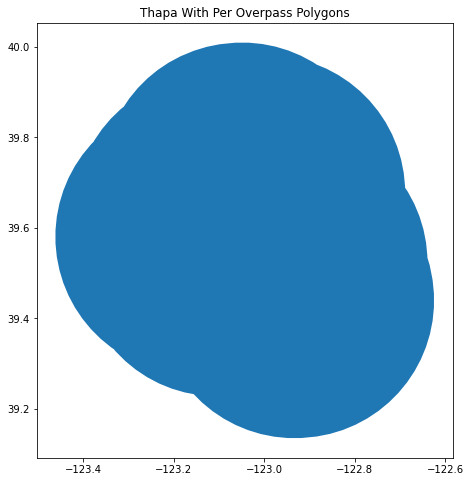

223


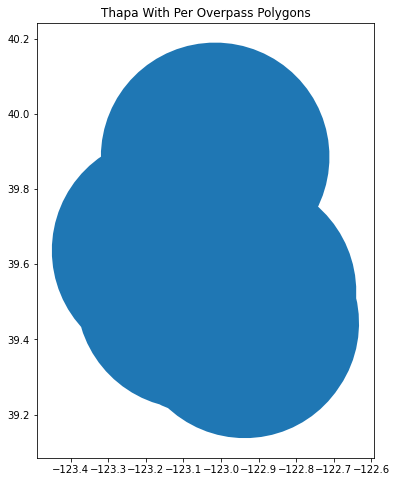

224


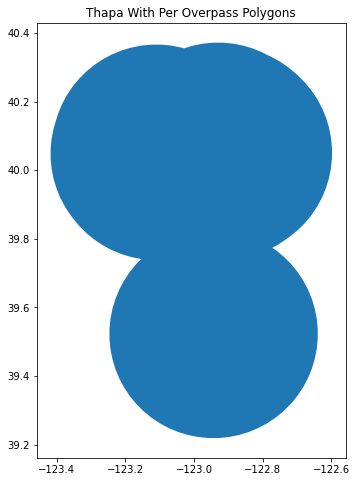

225


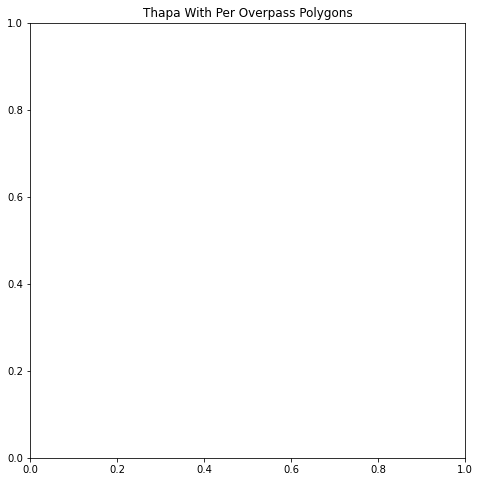

In [96]:
for ii in np.arange(222,226):
    print(ii)
    fig, ax = plt.subplots(figsize=(20,8)) #set up the figure
    fire_series_new['geometry'].iloc[ii-1:ii].buffer(0.3).plot(ax=ax)# cmap='OrRd')
    plt.title('Thapa With Per Overpass Polygons')
    plt.show()
#

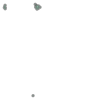

In [67]:
shape_new_save

In [101]:
fire_series_new[0:350]

,Incident Number,Fire Name,Current Day,Current Overpass,Lat Fire,Lon Fire,Number of NEW VIIRS points,NEW FRP,geometry
0,11843929.0,AUGUST COMPLEX,2020-08-18,800.0,39.659444,-122.808889,0.0,0.00,"POLYGON ((-122.80489 39.65944, -122.80491 39.6..."
1,11843929.0,AUGUST COMPLEX,2020-08-18,854.0,39.659444,-122.808889,12.0,41.89,"MULTIPOLYGON (((-122.67211 39.75618, -122.6719..."
2,11843929.0,AUGUST COMPLEX,2020-08-18,948.0,39.659444,-122.808889,43.0,94.50,"MULTIPOLYGON (((-122.66855 39.75679, -122.6684..."
3,11843929.0,AUGUST COMPLEX,2020-08-18,1036.0,39.659444,-122.808889,14.0,49.86,"MULTIPOLYGON (((-122.66841 39.75006, -122.6684..."
4,11843929.0,AUGUST COMPLEX,2020-08-18,2018.0,39.659444,-122.808889,61.0,2140.28,"MULTIPOLYGON (((-122.67896 39.74526, -122.6789..."
...,...,...,...,...,...,...,...,...,...
345,11843929.0,AUGUST COMPLEX,2020-10-20,1006.0,39.659444,-122.808889,3.0,2.40,"MULTIPOLYGON (((-123.08738 40.24582, -123.0874..."
346,11843929.0,AUGUST COMPLEX,2020-10-20,2036.0,39.659444,-122.808889,1.0,1.19,"POLYGON ((-123.10981 40.26429, -123.10983 40.2..."
347,11843929.0,AUGUST COMPLEX,2020-10-22,1018.0,39.659444,-122.808889,2.0,1.61,"MULTIPOLYGON (((-123.34414 40.42990, -123.3441..."
348,11843929.0,AUGUST COMPLEX,2020-10-26,1042.0,39.659444,-122.808889,1.0,0.47,"POLYGON ((-123.37946 40.39735, -123.37948 40.3..."


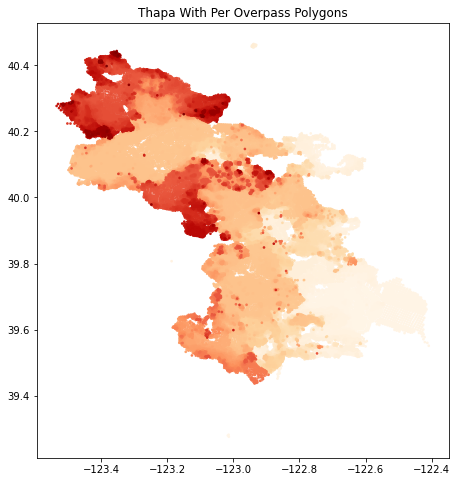

In [103]:

fig, ax = plt.subplots(figsize=(20,8)) #set up the figure
fire_series_new.iloc[0:349].plot(ax=ax,cmap='OrRd')
plt.title('Thapa With Per Overpass Polygons')
plt.show()

In [105]:
hi = fire_series_new['geometry']
hi
therest = fire_series_new[['Incident Number', 'Fire Name', 'Current Day','Current Overpass','Lat Fire', 'Lon Fire','Number of NEW VIIRS points', 'NEW FRP']]
therest

fiona.supported_drivers
hi.to_file("august_complex_polygons_only_VIIRS_overpass.geojson", driver='GeoJSON')
therest.to_csv('august_complex_polygons_attributes_VIIRS_overpass.csv')

In [6]:
#lat_old and lon_old are the detects used to build the prev version of today's polygon
def build_today_polygon(shape, lats, lons, lats_old, lons_old, bf, plot_evol):
    shape_buff = shape.buffer(bf)
    
    #find the points that are inside the buffer
    pairs = zip(lons, lats)
    xs, ys = shape_buff.exterior.xy #get the edges of the buffered shape
    poly_path = Path(np.stack([xs, ys], axis=1)) #make them into a path
    poly_path_contains = poly_path.contains_points(np.stack([lons,lats],axis=1)) #get the points that are in the shape REPLACES FOR LOOP
    

    #grab the new points
    lat_new = lats[np.where(poly_path_contains==True)[0]]
    lon_new = lons[np.where(poly_path_contains==True)[0]]

    #make a shape around them
    
    tups = [list((lon_new[i], lat_new[i])) for i in range(len(lat_new))]
    mp = MultiPoint(tups).convex_hull
    
    
    if plot_evol == 1: #plot the new polygon
        print(len(lat_new), len(lon_new))
        m = gpd.GeoSeries(mp)
        m.plot()
        plt.scatter(lon_new, lat_new, c = 'k')
        plt.scatter(lon_fire, lat_fire, c='r')
        plt.title('Updated shape and points')
        plt.show()
        
    if (len(lat_new)-len(lats_old))>0: #if we are adding points 
        print('Time for recursive call')
        return build_today_polygon(mp, lats, lons, lat_new, lon_new, bf, plot_evol)
    else:
        return mp, lat_new, lon_new #MAY WANT TO RETURN A BUFFERED VERSION OF THE POLYGON
    

In [ ]:
print(dates[0:72])